# Data Analysis in Astronomy / Physics: Bayesian Statistical Inference
<br>

## António Cesário
#### Master's in Experimental Physics, FCUP

## Introdução
Este trabalho trata-se do meu projeto para a cadeira de Análise de Dados em Física, do 1º ano do Mestrado em Física Experimental na FCUP. Foi feita a análise Bayesiana do espetro de um astro com o objetivo de determinar a largura espectral e posição de uma risca de emissão. O código para este trabalho foi escrito em **R**.

**ETA:** No meu pc, o documento demora sensivelmente 50s para correr todas as células.

In [1]:
library('ggplot2')
library('pracma')
library('rgl')
library('latex2exp')
library('knitr')

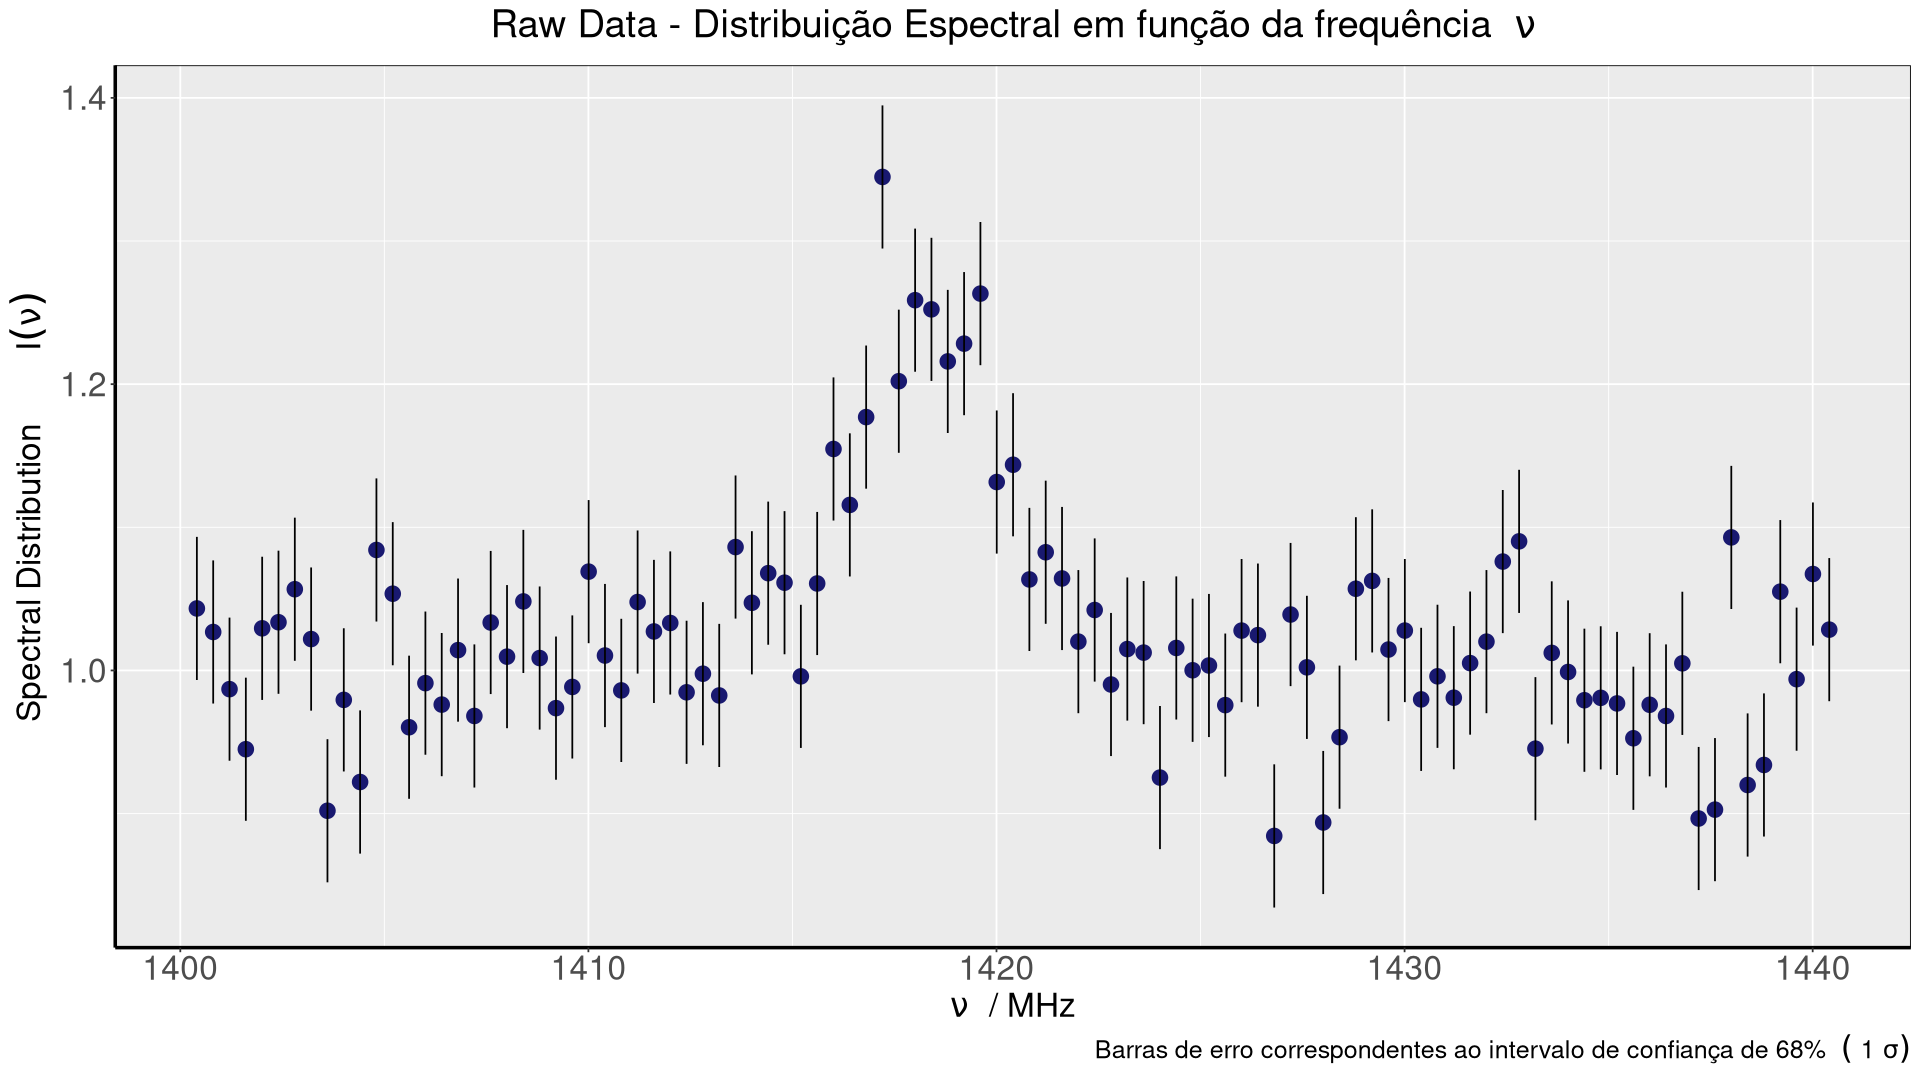

In [25]:
# Raw data visualization
options(repr.plot.width=16, repr.plot.height=9)
dados <- read.csv(file = 'data_Antonio.R',sep=' ', header=FALSE)
names(dados) = c('freq','intensity') # change data.frame header's names
# plot( dados,
#       main = expression(paste('Raw Data - Distribuição Espectral centrada em ',nu[0])),
#       xlab = expression(paste(nu-nu[0],' / MHz')),
#       ylab = expression(paste('Spectral Distribution\t',  I(nu) ))
#       )

# ggplot theme to ease visualization in jupyter notebook documents
jupyter.theme <- function(base_size = 13, base_family = "", base_line_size = base_size/22, 
                         base_rect_size = base_size/22) {         
  theme(
    legend.key.size = unit(10, 'cm'), #change legend key size
    legend.key.height = unit(1, 'cm'), #change legend key height
    legend.key.width = unit(1, 'cm'), #change legend key width
    legend.title = element_text(size=18), #change legend title font size
    legend.text = element_text(size=15), #change legend text font size
    plot.title = element_text(size=23,hjust = 0.5),
    axis.title = element_text(size = 20),                               
    axis.text.x = element_text(size = 20),                              
    axis.text.y = element_text(size = 20),                              
    plot.caption = element_text(size = 15, face = "italic"),            
    #panel.background = element_rect(fill="white"),                      
    axis.line = element_line(size = 1, colour = "black"),
    strip.background = element_rect(fill = "#cddcdd"),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5),
        strip.text = element_text(colour = "black"),
        legend.key=element_blank()
  )
}

# actual plotting
ggplot( aes(x = freq, y = intensity), data = dados) +
    geom_point( size = 4 , colour = 'midnightblue' ) +
    xlab(bquote(nu~' / MHz')) +
    ylab(bquote('Spectral Distribution\t' ~ I(nu))) +
    labs(title = bquote('Raw Data - Distribuição Espectral em função da frequência '~nu),
        caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma))) + 
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05)) + 
    jupyter.theme()

## A. Question A

A análise desta alínea segue de muito perto a que está descrita no capítulo 3 do livro **[1]**. Queremos avaliar a existência de uma risca espectral na gama de frequências analisada experimentalmente. Para isso, foi proposta uma teoria em que a emissão é caracterizada pela seguinte equação

$$
\begin{align}
G(\nu) &= 1 \pm \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu-\nu_{0}\right)^{2}}{g^{2}}\right\}\\
+ &\equiv \textrm{a risca é de emissão}\\
- &\equiv \textrm{a risca é de absorção}
\end{align}
$$

onde $\nu_0$ (posição central do pico) e $g$ (1/2 da **FWHM**) são parâmetros livres da teoria. Propõem-se, portanto, os modelos 

$$
\begin{align}
G^0 &\equiv \textrm{distribuição uniforme na gama de frequências apresentada.}\\
G^+ &\equiv \textrm{emissão espectral caracterizada por $\nu_0$ e $g$.}
\end{align}
$$

Para testar qual destes modelos descreve melhor os dados obtidos, irei recorrer a uma análise Bayesiana dos mesmos, onde primeiro irei determinar o *Odds Ratio* entre os modelos $G_0$ e $G^+$ assumindo $g=2$, ao qual irei chamar

$$
G_2^+ \equiv \textrm{emissão espectral caracterizada por $\nu_0$ com $g=2$.}
$$

que apresenta apenas um parâmetro livre, a posição da risca espectral $\nu_0$.

### A.1 Cálculo de $\mathcal{O}_{0}^{2+}$

O *Odds Ratio* entre os modelos $G_2^+$ e $G^0$ é dado por

$$
\begin{aligned}
\mathcal{O}_{0}^{2+} &= \dfrac{p\left(G_2^{+} \mid D, I\right)}{p\left(G^{0} \mid D, I\right)} \\
&=\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} \cdot \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)}
\end{aligned}
$$

onde identificamos os termos

$$
\begin{aligned}
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid \mathrm{I}\right)} &\equiv \textrm{razão entre priors}\\
\dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} &\equiv \textrm{fator de Bayes}
\end{aligned}
$$

assumindo ignorância total sobre qual dos modelos caracteriza melhor os dados,

$$
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} = 1
$$

logo

$$
\mathcal{O}_{0}^{2+} = \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} \quad \textrm{(fator de Bayes)}
$$

Se $\mathcal{O}_{0}^{2+} >> 1$ o modelo $G^+$ descreve os dados com maior verossemelhança. O oposto caso $\mathcal{O}_{0}^{2+} << 1$. O método para calcular os termos acima será apresentado mais adiante, na discussão da determinação da probabilidade pedida.

### A.2 Cálculo de $p\left( D \mid \nu_0 , G_2^+, I\right)$ - ( *Likelihood* do modelo $G_2^+$ assumindo $\nu_0$)

Admitindo que os resultados de cada medição são **independentes**, a probabilidade de obter os dados da experiência assumindo o modelo $G^+$ com $\nu_0 = \nu_0$ é dada por

$$
\begin{align}
p\left(D \mid G_2^{+}, \nu_{0}, I\right) &= \prod_{i=1}^{N} p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right)\\
    &= \prod_{i=1}^{N} p\left(E_{i} \mid G^{+}, \nu_{0}, I\right)
\end{align}
$$

$$
\begin{align}
p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter o valor $d_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }\\
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter um erro de $e_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }
\end{align}
$$

O valor medido no bin $i$, $d_i$, é, à luz do modelo $G_2^+$, dado por

$$
\begin{align}
d_i &= f_i + e_i\\
f_i &= 1 + \frac{1}{g} \sqrt{\frac{\log 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu_i-\nu_{0}\right)^{2}}{g^{2}}\right\}
\end{align}
$$

onde $f_i$ é o valor previsto pelo modelo e $e_i$ o erro da medição. É-nos dito que o erro tem forma Gaussiana com um desvio padrão de $\sigma = 0.05 \textrm{ MHz}$ logo podemos escrever

$$
\begin{align}
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &= \frac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{e_{i}^{2}}{2 \sigma^{2}}\right\}\\
&= \dfrac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{\left(d_i-f_i\right)^{2}}{2 \sigma^{2}}\right\}
\end{align}
$$

concluimos, portanto, que

$$
p\left(D \mid G_2^{+},\nu_0, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

onde, mais uma vez, $d_i$ é o valor obtido no bin $i$ e $f_i$ o valor previsto pelo modelo $G_2^+$ para esse mesmo bin.

Para determinar a Likelihood global do modelo $G_2^+$, ***Marginal Likelihood***, precisamos de marginalizar a *Likelihood* acima nos seus parâmetros livres, neste caso em $\nu_0$. Voltaremos a este ponto depois de determinar a Likelihood de $G^0$.

#### A.2.1 Cálculo de $p\left( D \mid G^0, I\right)$ - (*Likelihood* do modelo $G^0$)

O modelo $G^0$ assume que o espectro obtido experimentalmente deve de ser constante $(=1)$ e não tem parâmetros livres. Assim, usando a mesma argumentação que na derivação da *Likelihood* anterior,

$$
d_i = 1 + e_i
$$

e portanto

$$
p\left(D \mid G^{0}, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-1\right)^{2}\right\}
$$

### A.3 Cálculo de $p\left(D \mid G_2^{+}, I\right)$ - ( Likelihood Marginal de $G_2^+$ )

A *Likelihood* que queremos determinar nesta secção é dada por

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \operatorname{d\nu_0} p \left(\nu_0 \mid G_2^{+}, I \right) p\left(D \mid \nu_0,G_2^{+}, I\right)\\
$$

#### A.3.1 Escolher $p \left(\nu_0 \mid G_2^{+}, I \right)$ - ( *prior* de $\nu_0$)

Para escolher a ***prior*** de $\nu_0$, $p \left(\nu_0 \mid G_2^{+}, I \right)$, primeiro reconhecemos que este termo se trata de um **parâmetro de localização** da distribuição, pelo que será aconselhado escolher

$$
p \left(\nu_0 \mid G_2^{+}, I \right) = \dfrac{1}{\Delta\nu}
$$

para impôr a condição da invariância de translação neste parâmetro. Como só nos é fornecida informação relativamente à gama de frequências estudada experimentalmente, irei assumir que o pico de emissão existe nesta mesma gama de frequências, ou seja,

$$
\begin{align}
\Delta \nu 
    &= \nu_{\textrm{Máximo medido}} - \nu_{\textrm{mínimo medido}}\\
    &= 1440.4 - 1400.4\\
    &= 40 \textrm{ MHz}
\end{align}
$$

Para além da invariância de translação, outra razão que me levou a escolher uma *prior* uniforme para este parâmetro, em vez de uma de Jeffreys, está relacionada com o facto de $\Delta\nu$ não se estender por várias ordens de grandeza, pelo contrário,

$$
\dfrac{\Delta\nu}{\nu_{min}} \approx 3 \%
$$

o que significa que o acréscimo de probabilidade para maiores valores de $\nu_0$ devido à *prior* uniforme será pequeno.
Com isto concluimos que 

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados das alíneas A e B propostas. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

### A.4 Determinar $p\left(D\mid G^+,I\right)$ - (*Likelihood* do modelo $G^+$)

Finalmente, para determinar a *Likelihood* global associada ao modelo $G^+$, temos que marginalizar $p\left(D\mid g, G^+,I\right)$ no parâmetro $g$, ou seja,

$$
\begin{align}
p\left(D \mid G^{+}, I\right)
    &= \int \operatorname{dg} p \left(g \mid G^{+}, I \right) p\left(D \mid g,G^{+}, I\right)\\
    &= \int \dfrac{\operatorname{dg}}{4\log\left(10\right)\cdot g}\left[
    \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
    \right]
\end{align}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados desta questão. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

### $\mathcal{A}$ Cálculo de $\mathcal{O}_{0}^{2+}$
Na célula abaixo estão implementadas as rotinas principais necessárias para avaliar as quantidades necessárias para o resto da alínea A.


In [3]:
# Defining Constants trhoughout the question
Nu.data <- dados[1]
G.data <- dados[2]

sigma <- 0.05
N <- 101

nu.min <- Nu.data$freq[1] # minimum value of \nu in data
nu.max <- tail(Nu.data$freq,n=1) # maximum of \nu in data
Delta.nu <- nu.max - nu.min # range of frequencies in data


# Likelihood - G0 hypothesis - Final Calculation
Likelihood_G.null <- function(){
    summation <- sum( (G.data - 1.)^2. ) * (- 0.5 / sigma^2. )
    
    exp(summation) / ( sqrt(2.*pi) * sigma ) ^ N
}

# Theoretical Emission Curve - G+ hypothesis 
emission_spec <- function(nu_0, g) {
    # nu_0 : free parameter, postion of the emission spectrum
    # g : free parameter, scale of the emission spectrum
    f1 <- exp( - log(2) * (Nu.data-nu_0)^2 / g^2 )
    1. + f1 * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_Likelihood_G.2plus <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_mean_calc <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    nu_0 * exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# # Marginal Likelihood - G2+ hypothesis - Integral Calculation
Likelihood_G.2plus <- function(){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# Marginal Likelihood - G+ hypothesis - Double Integral Calculation
Likelihood_G.plus <- function(){
    
    integral2(Vectorize(function(g,nu_0){
        
        1 / ( Delta.nu * ( g * log(g.max/g.min) ) * ( sqrt(2*pi) * sigma ) ^ N ) * # 1 / (...) * \\ exp(...)

        exp(sum(( G.data - 1 - exp(-log(2)*(Nu.data-nu_0)^2/g^2) * sqrt(log(2)/pi)/g) ^2) * (- 0.5 / sigma^2 )) 

        }), xmin=g.min, xmax=g.max, ymin=nu.min, ymax=nu.max)
    }

# Mean Value
calc_mean <- function(){
    
    integrate(Vectorize(integrand_mean_calc ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)

}

In [4]:
# A.1 Odds Ratio
# (cell runtime: < 4s)
L.G0 = Likelihood_G.null()
L.G2p = Likelihood_G.2plus()
G2p.marginal = L.G2p$value
G2p.prior = 1 / Delta.nu

In [5]:
odds_ratio = format( L.G2p$value / L.G0 , scientific = TRUE , digits = 5 )
num_error = format( L.G2p$abs.error / L.G2p$value * 100 , scientific = TRUE , digits = 1 )

cat('Odds Ratio = ', odds_ratio)
cat('\nwith a numerical error of', num_error,'%')

Odds Ratio =  4.5916e+45
with a numerical error of 2e-03 %

## B. Question B

Da célula anterior, concluimos com segurança que o modelo $G_2^+$ descreve os dados obtidos com muita maior verossemelhança que $G^0$. Estamos agora em condições de determinar a **probabilidade posterior** de cada $\nu_0$ à luz de $G_2^+$ tendo em conta os dados, ou seja, podemos determinar a *pdf (probability density function)* de $\nu_0$, que iremos usar para fazer a análise estatística do modelo escolhido. Relembrando o Teorema de Bayes,

$$
p\left(\nu_0 \mid G_2^{+}, D, I\right) = \dfrac{p\left(\nu_0 \mid G_2^+ , I\right)}{p\left(D \mid G_2^{+} ,I\right)} p\left( D \mid \nu_0, G_2^+, I\right)
$$

$$
\begin{align}
p\left(\nu_0 \mid G_2^{+}, D, I\right) &\equiv \textrm{Probabilidade posterior}\\
p\left( D \mid \nu_0, G_2^+, I\right) &\equiv \textrm{Likelihood de assumindo $\nu_0$ }\\
p\left(D \mid G_2^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(\nu_0 \mid G_2^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

Os principais valores que queremos determinar nesta alínea são definidas pelas equações que se seguem:

$$
\begin{align}
0 &\equiv \left.\dfrac{\partial p\left(\nu_0 \mid G_2^{+}, D, I\right) }{\partial \nu_0}\right|_{\nu_0=\hat{\nu}}\\
\langle\nu_0\rangle &\equiv \int_{\nu_{\textrm{min}}}^{\nu_{\textrm{max}}} \operatorname{d\nu_0} \nu_0 \cdot p\left(\nu_0 \mid G_2^{+}, D, I\right)\\
0.5 &\equiv \int_{\nu_{\textrm{min}}}^{\nu_{1/2}} \operatorname{d\nu_0} p\left(\nu_0 \mid G_2^{+}, D, I\right)
\end{align}
$$

onde 

$$
\begin{align}
\hat{\nu_0} &\equiv \textrm{moda}\\
\langle\nu_0\rangle &\equiv \textrm{média}\\
\nu_{1/2} &\equiv \textrm{mediana}
\end{align}
$$

Antes de determinar estes valores, é conveniente primeiro saber qual é a forma *pdf* obtida. Como seria de esperar, esta função estende-se por várias ordens de grandeza, pelo que será conveniente representá-la numa escala logarítimica.

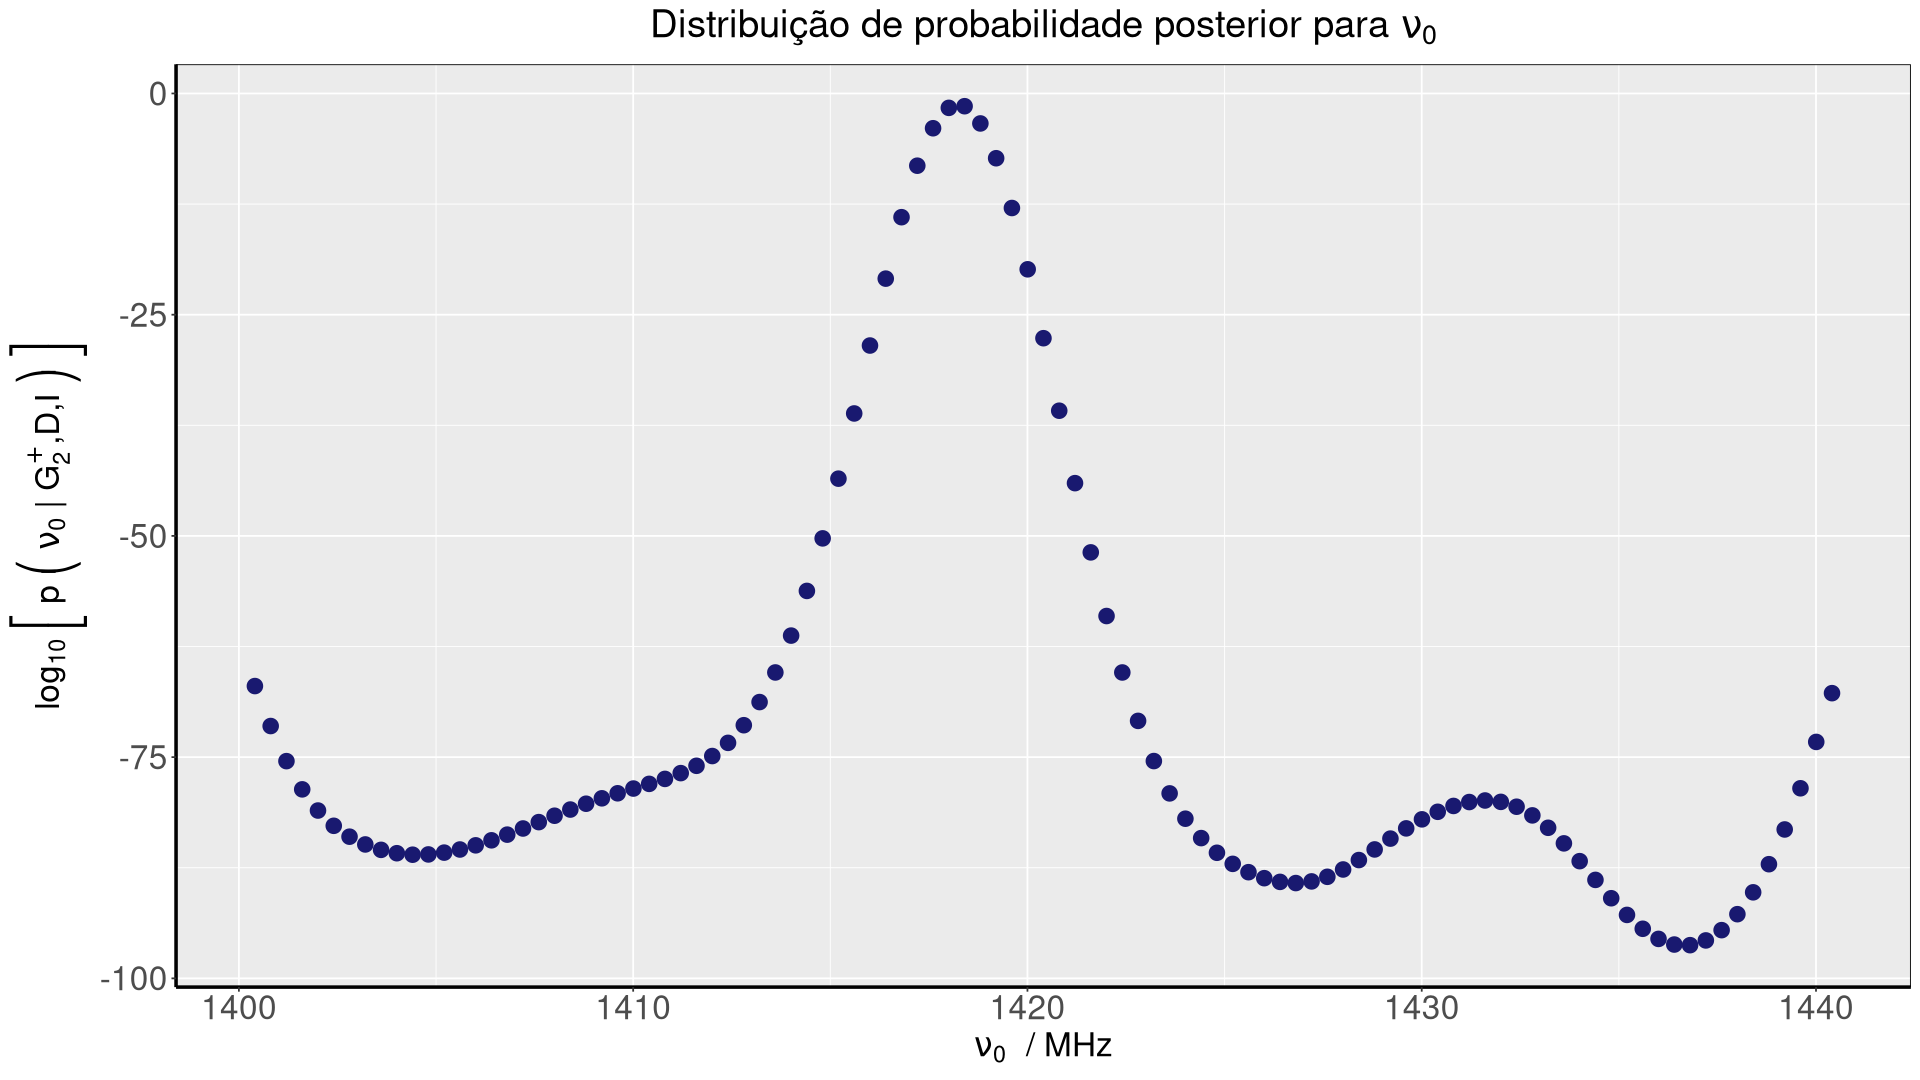

In [6]:
# #############################################################
# Likelihood Function
# #############################################################
Likelihood_G2p <- function(nu_0){
    
    fi <- emission_spec( nu_0 , 2 )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# #############################################################
# Vectorize previous function
# #############################################################
vec_Likelihood_G2p <- function(NU_0){
    
    Vectorize(Likelihood_G2p , vectorize.args = 'nu_0')(NU_0)
    
}

# #############################################################
# Posterior Probability - G2+
# #############################################################
posterior_G2p <- function(nu_0){
    G2p.prior * ( vec_Likelihood_G2p(nu_0) / G2p.marginal )
}

# #############################################################
# Plotting results
# #############################################################

# Calculation of the pdf
G2p.posterior = posterior_G2p(Nu.data$freq)

# Inserting the values into a dataframe
df.extended <- dados
df.extended$posterior <- G2p.posterior
df.extended$log10_posterior <- log(G2p.posterior,base=10)

# Plot of the above
ggplot(data = df.extended , aes(freq) ) +

    geom_point(aes(y=log10_posterior) , size = 4 , colour = 'midnightblue' )+
    
    labs(title = bquote('Distribuição de probabilidade posterior para'~nu[0]),
         #caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu[0]~' / MHz'),
         y =  TeX(r'($log_{10} \, \left[ \, p\, \left(\, \nu_0 \, | \, G_2^{+}, D, I \,\right) \, \right]$)'),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

In [7]:
# #############################################################
# Moda - Funções para a determinar através da derivada de log(pdf)
# #############################################################

# log(pdf) - differentiate to determine the higher Likelihood value (moda)
log.pdf_G2p <- function(nu){
    pdf.value = log( integrand_Likelihood_G.2plus(nu) / G2p.marginal , base = 10 )
}

# derivatve of log(pdf) - the root of this function will be the higher Likelihood value
# provided we give the proper interval
Derivative_log.pdf_G2p <- function(nu){
    fderiv( Vectorize(log.pdf_G2p, vectorize.args='nu') , nu )
}


# #############################################################
# MÉDIA - Funções para a calcular
# #############################################################

# nu_0 * Likelihood Function - nu_0 mean calculation
mean.x.Likelihood_G2p <- function(nu_0){    
    nu_0 * vec_Likelihood_G2p(nu_0)
}

# Marginal Likelihood - G2+ hypothesis - Integral Calculation
Likelihood_G.2plus <- function(){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# Mean Value - just call function to determine the value
pdf_mean <- function(){
    
    I = integrate(Vectorize(mean.x.Likelihood_G2p ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = nu.max,
              subdivisions = 100,
              rel.tol = 1e-5)
    
    I$rel.error = I$abs.error / I$value
    I$abs.error = I$abs.error / G2p.marginal
    I$value = I$value / G2p.marginal
    
    head(I)

}

# #############################################################
# Mediana - funções para a determinar
# #############################################################

# Cumulative function
pdf_cum_simple <- function(y){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = y, # <------------ we want to change this limit
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)

}

# Cumulative function - Vectorization of the upper limit - Used to plot Cum(nu_0)
pdf_cum <- function(nu){
    
    I = head( sapply( nu , pdf_cum_simple ) , 2 )
    
    values = array(as.numeric(unlist(I[1,])))
    abs.errors = array(as.numeric(unlist(I[2,])))
    
    rel.errors =  abs.errors / values
    values = values / G2p.marginal
    abs.errors = abs.errors / G2p.marginal
    log10.values = log(values,base=10)
    log.error.bars = rel.errors / log(10)
    
    data.frame(nu,values,abs.errors,rel.errors,log10.values,log.error.bars)
}

# Cumulative function - used for root finding
# the zero of this function gives us the median value of nu_0
pdf_cum_root <- function(y){
    
    I = integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.min,
              upper = y, # <------------ we want to change this limit
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)$value
    
    log(I / G2p.marginal) + log(2)
}


# pdf dataframe with log10 values
pdf_G2p <- function(nu){
    
    pdf.value = integrand_Likelihood_G.2plus(nu) / G2p.marginal
    log10.value = log(pdf.value,base=10)
    
    data.frame(pdf.value,log10.value)
}

### $\mathcal{B.1}$ Determinar a Mediana

Para determinar a mediana temos que descobrir quando é que $c\left(\nu\right) = 0.5$, onde

$$
c(\nu) = \int_{\nu_{\textrm{min}}}^{\nu} \operatorname{d\nu_0} p\left(\nu_0 \mid G_2^{+}, D, I\right)
$$

Para sabermos como varia a função cumulativa em função do limite superior do integral, podemos representar graficamente esta função para alguns pontos dos dados.

,nu,values,abs.errors,rel.errors,log10.values,log.error.bars
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1400.806,1.608690e-67,2.150390e-80,1.336734e-13,-66.79353,5.805361e-14
2,1402.006,1.608744e-67,9.745296e-74,6.057706e-07,-66.79351,2.630828e-07
3,1403.206,1.608744e-67,6.918883e-75,4.300799e-08,-66.79351,1.867813e-08
4,1404.406,1.608744e-67,5.585947e-72,3.472242e-05,-66.79351,1.507976e-05
5,1405.606,1.608744e-67,1.485643e-75,9.234800e-09,-66.79351,4.010623e-09
6,1406.806,1.608744e-67,9.745338e-74,6.057732e-07,-66.79351,2.630840e-07


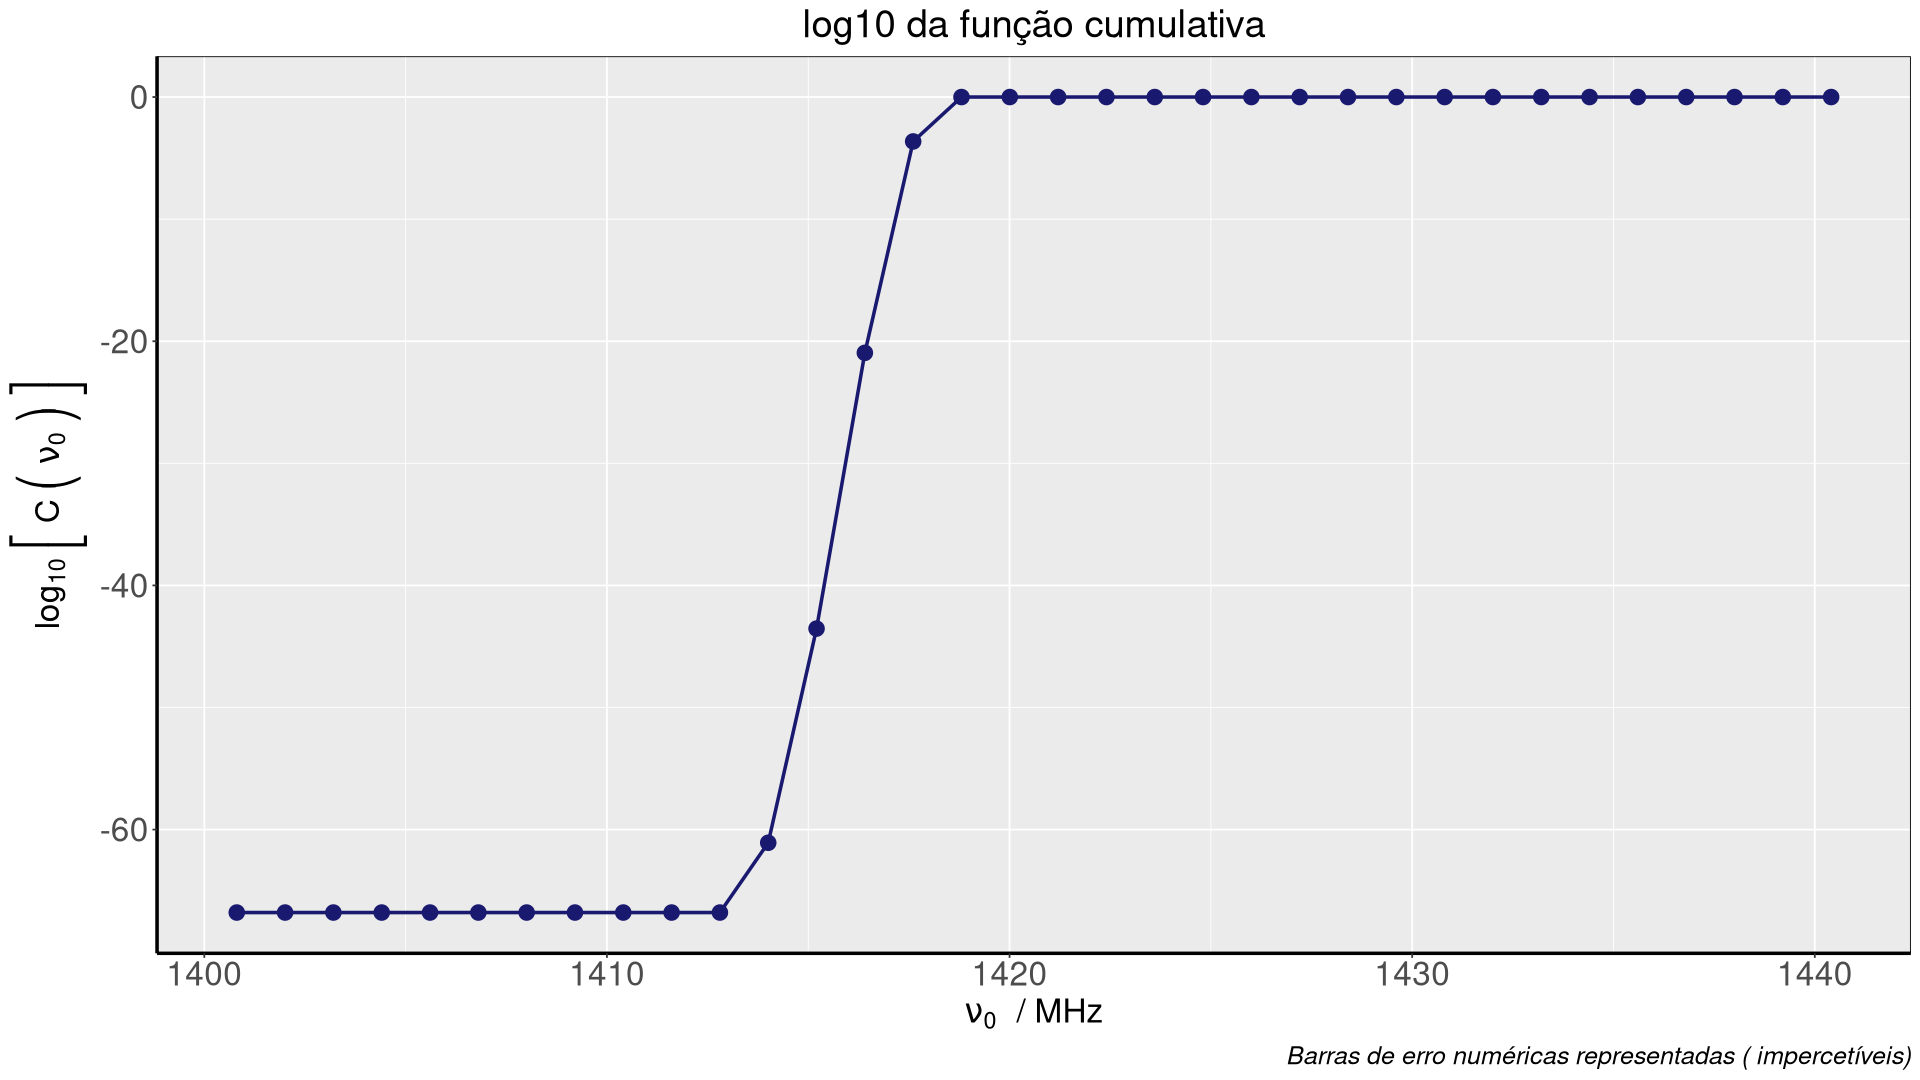

In [8]:
# #############################################################
# Calculate the cumulative function at several data points
# #############################################################

df.cum <- pdf_cum(Nu.data$freq[c(FALSE, TRUE, FALSE)])
head(df.cum)
# To save time c(FALSE, TRUE, FALSE) passes to the function only 1 value in every 3
# since we only want this to visualize how the C function varies with nu0

# #############################################################
# Plot the above result
# #############################################################

ggplot(data = df.cum , aes(nu) ) +
    
    geom_point( aes(y=log10.values) , size = 4 , colour = 'midnightblue') +
    geom_line( aes(y=log10.values) , size = 1 , colour = 'midnightblue')+

    geom_linerange(aes(ymin = log10.values - log.error.bars,
                       ymax = log10.values + log.error.bars), colour='black',size=2) + # error bars

    labs(title = bquote('log10 da função cumulativa'),
         caption = bquote('Barras de erro numéricas representadas ( impercetíveis)'),
         x = bquote(nu[0]~' / MHz'),
         y =  TeX(r'($log_{10} \, \left[ \, C\, \left(\, \nu_0 \,\right) \, \right]$)')
         )+

    #scale_color_manual(values = colors) +
    
jupyter.theme()

Com este gráfico podemos verificar que, mesmo em escala logarítimica, a função cumulativa varia bruscamente no intervalo $\left[1415.006,1420.006\right]$. Com base nesta informação, estabeleci estes limites como uma proposta ao intervalo que contêm a mediana. Os dois <code>TRUE</code> abaixo comprovam exatamente este ponto além de que o mesmo intervalo contém o intervalo de confiança de 95%, que será determinado mais à frente.

Posto isto, determinei a função cumulativa em vários pontos do intervalo referido e espaçados de 0.4, a sensibilidade do instrumento utilizado para medir as frequências.

Representando graficamente a linha $ y = - \log_{10} (2)$, a vermelho, podemos verificar que de facto a mediana está contida neste intervalo.

Does the interval contain -log10(2)? 

[1] TRUE


Does the interval contain 95% CL? 

[1] TRUE

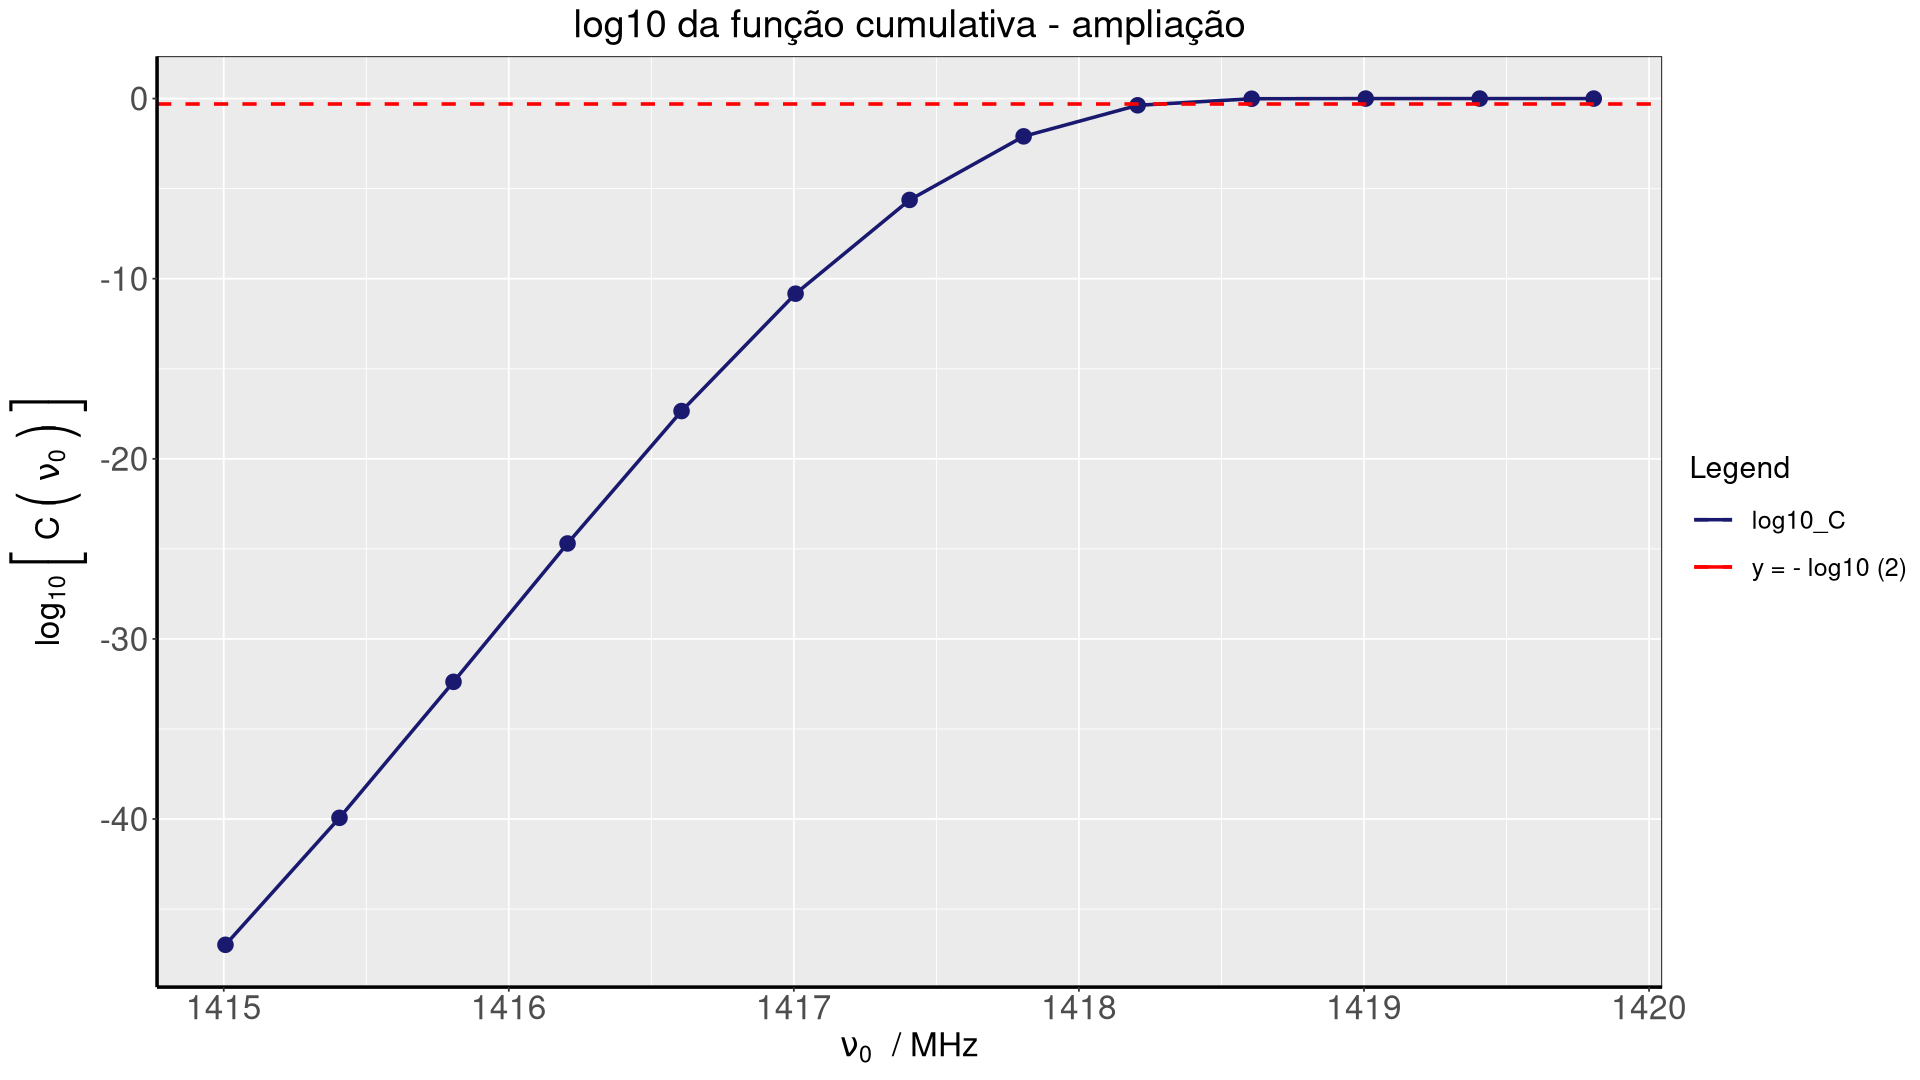

In [9]:
# #############################################################
# Calculate the cumulative function at a chosen range
# #############################################################
cum_lim1 = 1415.006
cum_lim2 = 1420.006

# #############################################################
# Prove that this range contains the 0.95 CL
# #############################################################
# to prove that this range contains the 0.95 % interval we just check
# if cum(lim1) < 0.95 < cum(lim2)
lim1 = pdf_cum(cum_lim1)$value
lim2 = pdf_cum(cum_lim2)$value

cat('Does the interval contain -log10(2)?','')
( lim1 < 1/2 )& (lim2 > 1/2)
cat('\nDoes the interval contain 95% CL?','')
( lim1 < 0.95 )& (lim2 > 0.95)

# Now we compute the cumulative function throughout this interval
df.cum2 <- pdf_cum(seq(cum_lim1,cum_lim2,by=0.4))

colors <- c("log10_C" = 'midnightblue' , 'y = - log10 (2)' = 'red')
ggplot(data = df.cum2 , aes(nu) ) +
    
    geom_point( aes(y=log10.values) , size = 4 , colour = 'midnightblue') +
    geom_line( aes(y=log10.values , colour = 'log10_C') , size = 1 )+
    
    geom_hline( aes(yintercept=-log(2,base=10),colour='y = - log10 (2)'), linetype="dashed", size=1) + 

    labs(title = bquote('log10 da função cumulativa - ampliação'),
         #caption = bquote('Barras de erro numéricas representadas ( impercetíveis)'),
         x = bquote(nu[0]~' / MHz'),
         y =  TeX(r'($log_{10} \, \left[ \, C\, \left(\, \nu_0 \,\right) \, \right]$)'),
         colour = 'Legend'
         )+

    scale_color_manual(values = colors) +
    
jupyter.theme()

Torna-se, portanto, bastante evidente que reduzimos o nosso problema de determinação da mediana ao problema de determinação do zero de uma função. Para fazer este cálculo em **R** basta chamar-mos a função <code>uniroot</code> e definir o intervalo em que queremos que o zero seja procurado, que será o intervalo referido acima.

Abaixo, **\$ root** corresponde ao zero que pretendemos determinar e **\$ f.root** o valor da função nesse ponto. Para mais informações sobre os outputs da função basta executar <code>?uniroot</code>.

In [10]:
# Mediana - calculation
root.mediana = uniroot(pdf_cum_root,
                       interval = c(cum_lim1,cum_lim2))
nu0_mediana = root.mediana$root
root.mediana

$root
[1] 1418.24

$f.root
[1] -0.000102072

$iter
[1] 10

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05

### $\mathcal{B.2}$ Determinar a Moda

Em vez de recorrer à derivada da *pdf* para determinar a moda, podemos simplesmente reconhecer que, como a função $\log$ é monótona e crescente, então os extremos de $\log\left[p\left(\nu_0 \mid G_2^{+}, D, I\right)\right]$ são os mesmos que os de $p\left(\nu_0 \mid G_2^{+}, D, I\right)$, ou seja,

$$
\begin{align}
0 &= \left.\dfrac{\partial p\left(\nu_0 \mid G_2^{+}, D, I\right) }{\partial \nu_0}\right|_{\nu_0=\hat{\nu}}\\
&= \left.\dfrac{\partial \log \left[p\left(\nu_0 \mid G_2^{+}, D, I\right)\right] }{\partial \nu_0}\right|_{\nu_0=\hat{\nu}}
\end{align}
$$

Mais uma vez, reduzimos o nosso problema à determinação do zero de uma função. Usando novamente <code>uniroot</code> obtemos o reusltado da célula abaixo.

In [11]:
# Moda - calculation
root.moda = uniroot(Derivative_log.pdf_G2p,
                    interval=c(cum_lim1,cum_lim2) )
nu0_moda = root.moda$root
root.moda

$root
[1] 1418.241

$f.root
[1] 4.432767e-08

$iter
[1] 6

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05

### $\mathcal{B.3}$ Determinar a Média


In [12]:
# Média - calculation
calc.mean = pdf_mean()
nu0_mean = calc.mean$value
calc.mean

$value
[1] 1418.241

$abs.error
[1] 4.662374e-07

$subdivisions
[1] 8

$message
[1] "OK"

$call
integrate(f = Vectorize(mean.x.Likelihood_G2p, vectorize.args = "nu_0"), 
    lower = nu.min, upper = nu.max, subdivisions = 100, rel.tol = 1e-05)

$rel.error
[1] 3.287435e-10


### $\mathcal{B.4}$ Determinar intervalo de confiança 95%

O método implementado abaixo é muito direto e foi realizado com simplicidade em mente, não estando preparado para determinar intervalos de confiança descontínuos. Esta abordagem só foi tomada porque efetivamente é possível verificar que a *pdf* não possui máximos locais na região de maior probabilidade, em torno do máximo absoluto. Em todo o caso, existe um passo de verificação se esta condição de facto é cumprida.

**Algoritmo:**
1. Gerar uma amostra de pontos num intervalo que sabemos conter o menor intervalo com 95% de probabilidade. <br> Neste caso irei utilizar $\left[1415.006,1420.006\right]$, que foi mencionado anteriormente, com um espaçamento de <code>0.1</code> entre pontos sucessivos.


2. Fazer a integração entre pontos sucessivos e armazenar os valores obtidos numa *dataframe* Nx3.<br>N é o tamanho da amostra. *Coluna1:* Índice das frequências na amostra. *Coluna2:* frequência do primeiro ponto do intervalo. *Coluna3:* integral entre o ponto da col2 e o que lhe segue.


3. Ordenar as áreas da *df (dataframe)* por ordem decrescente.


4. Fazer a soma cumulativa nas áreas do array. Acrescentar o novo array à *df* já existente.


5. Procurar o índice em que area > 0.95 e descartar os que estão abaixo desse, inclusive.<br> Note-se que isto resulta, dentro da nossa precisão, numa estimativa por defeito do CL uma vez que aceitamos apenas valores inferiores a 0.95.


6. Verificar que os índices restantes formam um intervalo contínuo.


7. A frequência mínima (máxima) presente nos índices restantes corresponde ao limite inferior (superior) do intervalo de confiança desejado.


In [13]:
# ################################################################
# pdf - variable lower and upper limits - used to determine the 0.95 confidence levels
# ################################################################

pdf_G2p.cl <- function(nu.L,nu.U){
    
    I = integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
              lower = nu.L,
              upper = nu.U,
              g = 2,
              subdivisions = 100,
              rel.tol = 1e-4)
    
    I$value / G2p.marginal
}

# ################################################################
# Confidence Interval - Calculation
# ################################################################

# ---------------------------- Step: 1 ---------------------------

# Guess upper and lower limits
# ( based on log(Likelihood) plot as well as considering it should be near nu_mean and nu_moda )
nu0_clL  = 1415.006
nu0_clU = 1420.006
step = 0.1

# Wanted confidence level
CL = 0.95

# Interval considered
interval = seq(nu0_clL, nu0_clU, by = step )
n = length(interval)

# Interval to dataframe
interval1 = interval[1:(n-1)]
df.cl = data.frame(interval1)

# array to save integrals (areas)
areas = vector(mode="numeric", length=(n-1))


# ---------------------------- Step: 2 ---------------------------
# Integrating through successive point in the interval
for (i in 1:(n-1)){
    
    areas[i] = pdf_G2p.cl(interval[i],interval[i+1])
    
}


# ---------------------------- Step: 3 ---------------------------
# Order areas in descending order
df.cl$areas = areas
df.cl = df.cl[order(df.cl$areas,decreasing = TRUE),]


# ---------------------------- Step: 4 ---------------------------
# Create vector with cumulative sum of ordered areas
df.cl$areas.cumsum = cumsum(df.cl$areas)


# ---------------------------- Step: 5 ---------------------------
# Check indexes where cumulative sum < CL
pass_indexes = sum(df.cl$areas.cumsum < CL) + 1 # +1 to include the first value that doesn't obey < CL
df.cl = df.cl[1:pass_indexes,]


# ---------------------------- Step: 6 ---------------------------
# Verify continuity of the interval
indexes = as.numeric(row.names(df.cl))
indexes = sort(indexes, decreasing = FALSE)
steps_array = indexes[2:length(indexes)] - indexes[1:length(indexes)-1]

# If the interval is continous, then every step of the sorted indexes array is 1. Thereferoe the following must be true
cat('O intervalo obtido é válido (contínuo)?','')
sum(steps_array == 1) == length(steps_array)


# ---------------------------- Step: 7 ---------------------------
# Check how far the obtained CL is from the objective
CL.diff = abs( df.cl[pass_indexes-1,3] - CL )

# Finally, get the upper and lower limits
nu0_clL = min(df.cl$interval)
nu0_clU = max(df.cl$interval) + step


# ################################################################
# print results
# ################################################################

cat('\n',CL*100,'% Confidence Interval = [ ',nu0_clL,' , ' , nu0_clU,' ]\n\n' )

CL.diff.str = format(CL.diff/0.95*100,scientific = FALSE , digits = 2 )
cat('[ 0.95 - CL obtido ] / 0.95 = ',CL.diff.str,'%')

O intervalo obtido é válido (contínuo)? 

[1] TRUE


 95 % Confidence Interval = [  1417.806  ,  1418.606  ]

[ 0.95 - CL obtido ] / 0.95 =  0.3 %

### $\mathcal{B.5}$ Sumário

Esta alínea está quase finalizada. Sumarizo abaixo os resultados obtidos e apresento também o gráfico pedido dos dados comparados com as curvas de emissão esperadas para $\nu_0$ correspondente à moda e aos extremos do 95% CL.

Na tabela abaixo represento as diferenças dos valores obtidos em relação à moda e normalizadas pela menor divisão medida nas frequências (<code>0.4</code>). Podemos ver claramente que os valores da média, mediana e moda são muito próximos enquanto que os extremos do intervalo de confiança 95% correspondem praticamente a um desvio correspondente à precisão do aparelho (desvio relativo próximo da uidade).

In [14]:
sumario = c('moda' = nu0_moda,
            'media' = nu0_mean,
            'mediana' = nu0_mediana,
            'clLower' = nu0_clL,
            'clUpper' = nu0_clU
           )

sumario = data.frame(sumario)
diff = (sumario$sumario - nu0_moda ) / 0.4
sumario$relative.diffs = diff
sumario$relative.diffs = lapply( sumario$relative.diffs , format, digits = 3)
sumario
# kable(sumario,format='html')

,sumario,relative.diffs
,<dbl>,<list>
moda,1418.241,0
media,1418.241,-1.06e-05
mediana,1418.240,-6.14e-05
clLower,1417.806,-1.09
clUpper,1418.606,0.914


<table>
 <thead>
  <tr>
   <th style="text-align:center;">   </th>
   <th style="text-align:center;"> $\nu$ </th>
   <th style="text-align:center;"> $\dfrac{\hat{\nu_0}-\nu}{ d\nu}$   </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> Moda - $\hat{\nu_0}$ </td>
   <td style="text-align:center;"> 1418.241 </td>
   <td style="text-align:center;"> 0 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> Média - $\langle\nu_0\rangle$ </td>
   <td style="text-align:center;"> 1418.241 </td>
   <td style="text-align:center;"> -1.06e-05 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> Mediana - $\nu_{1/2}$ </td>
   <td style="text-align:center;"> 1418.240 </td>
   <td style="text-align:center;"> -6.14e-05 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> CL lower - $\nu_{L}$ </td>
   <td style="text-align:center;"> 1417.806 </td>
   <td style="text-align:center;"> -1.09 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> CL upper - $\nu_{U}$ </td>
   <td style="text-align:center;"> 1418.606 </td>
   <td style="text-align:center;"> 0.914 </td>
  </tr>
</tbody>
</table>

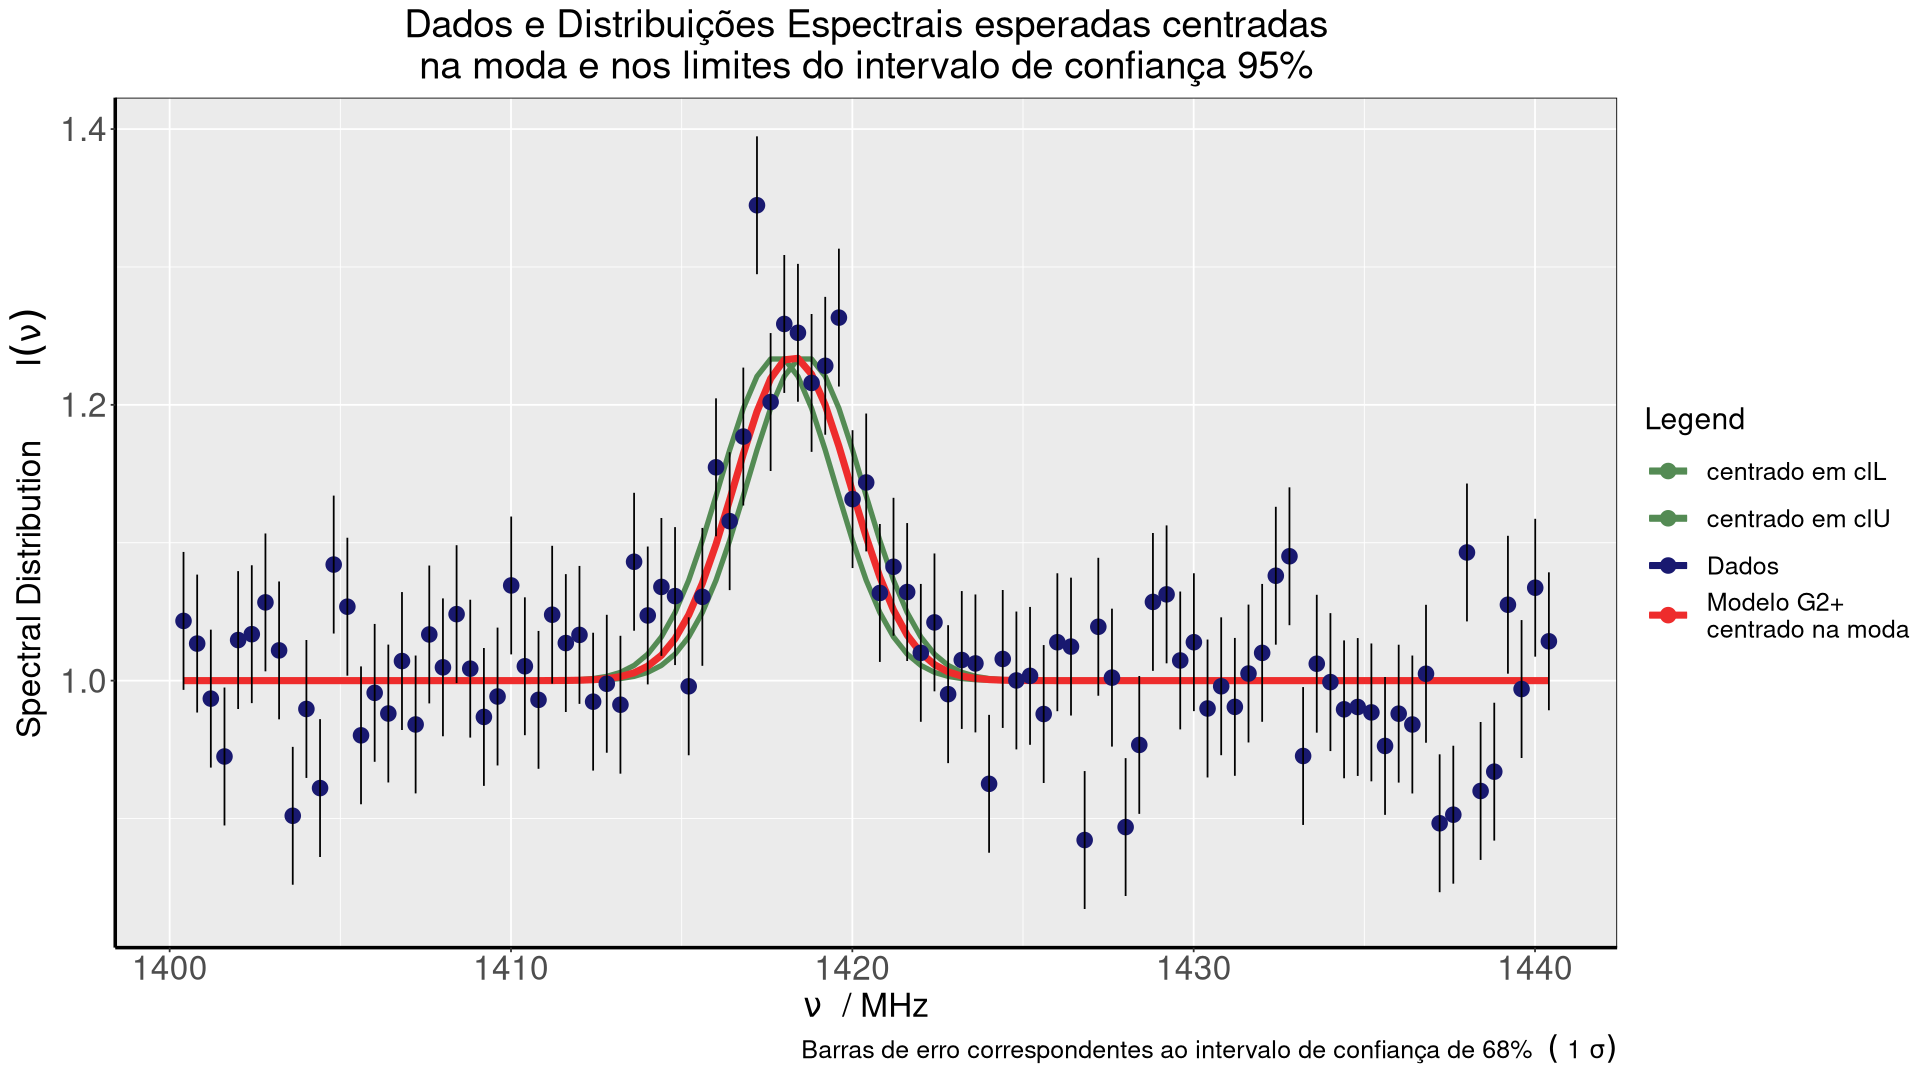

In [15]:
# Calculation of the theoretical emission curve at the most likely value of \nu_0

moda_emission_curve = emission_spec(nu0_moda,g=2)$freq
mean_emission_curve = emission_spec(nu0_mean,g=2)$freq
clL_emission_curve = emission_spec(nu0_clL,g=2)$freq
clU_emission_curve = emission_spec(nu0_clU,g=2)$freq

df.extended$nu0_moda <- moda_emission_curve
df.extended$nu0_clL <- clL_emission_curve
df.extended$nu0_clU <- clU_emission_curve

# Plot of the above
colors <- c("Dados" = 'midnightblue',
            'Modelo G2+\ncentrado na moda' = 'firebrick2',
            'centrado em clL' = 'palegreen4',
            'centrado em clU' = 'palegreen4'
           )
ggplot(data = df.extended , aes(freq) ) +

    geom_line(aes(y=nu0_clL,colour='centrado em clL') , size = 1.5 )+
    geom_line(aes(y=nu0_clU,colour='centrado em clU') , size = 1.5 )+
    geom_line(aes(y=nu0_moda,colour='Modelo G2+\ncentrado na moda') , size = 2 )+
    
    geom_point( aes(y=intensity,colour = 'Dados') , size = 4 ) +
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05),colour='black') + # error bars

    
    labs(title = bquote('Dados e Distribuições Espectrais esperadas centradas\nna moda e nos limites do intervalo de confiança 95%'),
         caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu~' / MHz'),
         y = bquote('Spectral Distribution\t' ~ I(nu)),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

## C. Questão C

Abaixo encontra-se implementado o algoritmo de Metropolis-Hastings para a criação de uma cadeia de Markov com a finalidade de simular a distribuição de probabilidades descrita por

$$
p\left(\nu_0 , g \mid G^{+}, D, I\right) = \dfrac{p\left(\nu_0,g \mid G^+ , I\right)}{p\left(D \mid G^{+} ,I\right)} p\left( D \mid \nu_0 ,g , G^+, I\right)
$$

$$
\begin{align}
p\left( D \mid \nu_0,g , G^+, I\right) &\equiv \textrm{função de Likelihood}\\
p\left(D \mid G^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(\nu_0 ,g \mid G^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

onde $\nu_0$ e $g$ são os parâmetros livres do modelo $G^+$, o modelo que assume a existência de uma risca espectral caracterizada por

$$
G(\nu) = 1 + \frac{1}{g} \sqrt{\frac{\log 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu-\nu_{0}\right)^{2}}{g^{2}}\right\}
$$

Seguindo uma argumentação idêntica à da **Questão A**, o nosso primeiro objetivo será determinar a probalidade prévia dos parâmetros livres. Assumindo que $\nu_0$ e $g$ são independentes, então

$$
p\left(\nu_0 ,g \mid G^+ , I\right) = p\left(\nu_0 \mid G^+ , I\right) p\left(g \mid G^+ , I\right)
$$

onde, como já foi discutido na **QA**, 

$$
p\left(\nu_0 \mid G^+ , I\right) = \dfrac{1}{\Delta \nu}
$$

com $\nu_0 \in \left[1400.4, 1440.4\right]$. Para propôr a *prior* de $g$ relembro que esta escolha deve de ser ''cega'' às informações contidas nos dados, ou seja, devemos de basear-nos apenas nas características da recolha dos dados, e não nos seus resultados. Os instrumentos utilizados no processo de medição possuem informação suficiente para podermos fazer uma escolha informada da *prior*de $g$.

Primeiro, como $g$ é um parâmetro de escala, uma vez que este controla não só a intensidade mas também largura do pico $\left(2g = \textrm{FWHM}\right)$, escolhemos uma *prior de Jeffreys* para caracterizar $g$, ou seja,

$$
p\left(g\mid G^+ , I\right) = \dfrac{1}{g}\dfrac{1}{\log\left(\dfrac{g_\textrm{max}}{g_\textrm{min}} \right)}
$$

com $g \in \left[g_\textrm{min}, g_\textrm{max}\right]$. O próximo passo será saber como determinar os limites deste intervalo.

Recorremos, portanto, às limitações dos instrumentos de medição utilizados. Como $g$ está associado à largura do pico de emissão, será sensato assumir que não conseguiríamos inferir com segurança a sua largura (a meia altura - FWHM) se esta fosse menor que a menor escala das frequências, $\delta \nu = 0.4\textrm{ MHz}$ e maior que a gama de frequências medida, $\Delta \nu = 40 \textrm{ MHz}$. Concluimos que

$$
\delta \nu < \textrm{FHWM} = 2g < \Delta \nu
$$

Com estas duas equações conseguimos estabelecer o intervalo em que a prior de $g$ está definida:

$$
\begin{align}
g_\textrm{max} &= \dfrac{\Delta\nu}{2}\\
&= 20\\\\
g_\textrm{min} &= \dfrac{\delta\nu}{2}\\
&= 0.2
\end{align}
$$

logo, utilizando apenas as limitações da aquisição dos dados, concluimos que $g \in \left[0.2, 20\right]$.

Abaixo encontra-se implementado o algoritmo de Metropolis-Hastings para a criação de uma cadeia de Markov com a finalidade de simular a distribuição de probabilidades posterior e, com isso, determinar a *Marginal Likelihood* do modelo $G^+$. Irei assumir que o leitor já se contra familiarizado com este alogritmo, pelo que não o irei explicar aqui no texto. Acrescento, no entanto, que foram introduzidas 100 iterações de *burn-in (termalização)* no algoritmo, para procurar descorrelacionar os resultados do *guess* inicial que é necessário fornecer o algoritmo.

Inicialmente determinei os coeficientes de autocorrelação ao longo da cadeia e mative apenas os índices descorrelacionados. No entanto, como não observei vantagens significativas ao executar este processo, decidi eliminar este passo da análise, que diminuia significativamente o tamanho da cadeia. O código que usei para este passo encontra-se comentado e devidamente destacado duas células de código abaixo.

In [16]:
# #############################################################################
# Cálculos, Constantes e Funções Auxiliares
# #############################################################################
dnu = Nu.data$freq[2]-Nu.data$freq[1]
g.min = dnu/2
g.max = Delta.nu/2
Delta.g = g.max - g.min

nu_i = Nu.data$freq
d_i = G.data$intensity
S_1 = sum((d_i-1)^2)

f_i <- function(nu,g){ exp(-log(2)*(nu_i-nu)^2/g^2) * sqrt(log(2)/pi) / g }

r.ratio <- function(t_nu,q_nu,t_g,q_g){
    
    if ( (g.min < q_g) & (q_g < g.max) & (nu.min < q_nu) & (q_nu < nu.max)){
        
        t_fi = f_i(t_nu,t_g)
        q_fi = f_i(q_nu,q_g)

        summation = sum( ( q_fi^2 - t_fi^2 ) - 2* (q_fi-t_fi)*(d_i-1) )
        r = exp(-0.5*summation/sigma^2) * (t_g/q_g)
        
        } else {r = 0}
    r
}

# #############################################################################
# Algoritmo de Metropolis-Hastings
# #############################################################################
metropolis <- function(N.therm, N.iterations){
    
    g.chain = numeric(N.iterations)
    nu.chain = numeric(N.iterations)
    U = runif(N.iterations)
    acceptances = 0
    
    # Thermalization Process
    for (i in 1:N.therm){
        q_g = rnorm(mean = t_g, sd = sd.g , n = 1)
        q_nu = rnorm(mean = t_nu, sd = sd.nu , n = 1)

        r = r.ratio(t_nu,q_nu,t_g,q_g)
        u = runif(1)

        if (u<r){   
            t_nu = q_nu
            t_g = q_g
        }}
    
    # Markov Chain Generation
    for (i in 1:N.iterations){
        q_g = rnorm(mean = t_g , sd = sd.g , n = 1)
        q_nu = rnorm(mean = t_nu , sd = sd.nu , n = 1)

        r = r.ratio(t_nu,q_nu,t_g,q_g)
        u = U[i]

        if (u<r){  
            acceptances = acceptances + 1
            
            t_nu = q_nu
            t_g = q_g

            g.chain[i] = t_g
            nu.chain[i] = t_nu

        }else{
            g.chain[i] = t_g
            nu.chain[i] = t_nu
        }
    }

    cat('Chain Length = ',acceptances,' in ',N.iterations,' iterations')
    cat('\nAcceptance Ratio of ',acceptances/N.iterations*100,'%')
    
    matrix(c(nu.chain,g.chain),ncol=2)
    
}

# #############################################################################
# Log Likelihood
# #############################################################################
log.Likelihood <- function(nu,g){
    fi = f_i(nu,g)
    
    (-0.5/sigma^2) * ( S_1 + sum( fi^2 - 2*(d_i-1)*fi ) )
}

vec.logL <- function(Nu,G){
    
    Vectorize(log.Likelihood,vectorize.args = c('nu','g'))(Nu,G)
}


# #############################################################################
# Redifine posterior
# #############################################################################
unnormalized.posterior <- function(nu,g){
    
    prior = 1 / ( Delta.nu * log(g.max/g.min) * g)
    L.likelihood = log.Likelihood(nu,g) 
    
    prior * exp(L.likelihood) / (sigma * sqrt(2*pi))^N
}

vec_unnormalized.posterior <- function(Nu,G){
    
    Vectorize(unnormalized.posterior,vectorize.args = c('nu','g'))(Nu,G)
}

In [33]:
# Create Markov Chain

# Propose Standard Deviation
sd.g = Delta.g/100
sd.nu = Delta.nu/200

# Propose Initial Guesses
t_g = 2
t_nu = nu0_moda

# Number of Iterations and time for Thermalization
N.therm = 100
N.iterations = 1e+5

# Computing MCMC
g.chain = metropolis(N.therm,N.iterations)
nu.chain = g.chain[,1]
g.chain = g.chain[,2]

mcmc = data.frame(nu.chain,g.chain)

# # ##############################################################################################
# # Autocorrelation Coefficients Determination
# # and MCMC trimming, removing autocorrelated terms.
# # ##############################################################################################

# d_tresh = 0.1
# g.acf = acf(g.chain,lag.max = 50,plot=T) # get the autocorrelation of t = 0 with other t's
# #g.acf = acf(nu.chain,lag.max = 100,plot=T) # get the autocorrelation of t = 0 with other t's
# d_lag = which(g.acf$acf < d_tresh)[1] # d_lag is the lag needed for the g values to become uncorrelated 

# g.chain_d = g.chain[seq(1,length(g.chain),by=d_lag)] # by choosing only every d_lag index on the chain, we get a Markov chain
# nu.chain_d = nu.chain[seq(1,length(g.chain),by=d_lag)] # of uncorrelated values

# cat('\n\nLag needed to uncorrelate chain values below ', d_tresh*100,'% = ',d_lag)
# cat('\nUncorrelated Chain Length = ', length(g.chain_d))

Chain Length =  48897  in  1e+05  iterations
Acceptance Ratio of  48.897 %

Estando construída a minha MCMC, o próximo objetivo será calcular a *marginal Likelihood* da *joint posterior*. Para simplificar a notação, a partir daqui irei referir-me às diferentes probabilidades da seguinte forma

$$
\begin{align}
\pi\left(X\right) &= p\left(\nu_0 ,g \mid G^+ , I\right) \\
\mathcal{L}\left(X\right) &= p\left( D \mid X, G^+, I\right)\\
p_\textrm{un}\left(X\right) &= \pi\left(X\right) \mathcal{L}\left(X\right)\\
C_M &= p\left(D \mid G^{+} ,I\right)\\
p_\textrm{n}\left(X\right) &= \dfrac{1}{C_M}\pi\left(X\right) \mathcal{L}\left(X\right)
\end{align}
$$

onde $X = \left(\nu_0,g\right) $ e **un** e **n** significam *unnormalized* e *normalized*, respetivamente. Para determinar o valor médio de uma função $f\left(X\right)$ temos que calcular o integral

$$
\langle f\left(X\right)\rangle = \int \textrm{d}X f\left(X\right)p_\textrm{n}\left(X\right)
$$

O objetivo da utilização das cadeias de Markov nesta alínea é a determinação destes integrais através de uma amostragem dos valores de $X$, que obedecem a uma distribuição

$$
\mathcal{F}_s\left(X\right) \equiv \textrm{distribuição de probabilidades da amostragem dos parâmetros da MCMC}
$$

que, segundo **[2]**, nos permite obter uma aproximação ao integral da seguinte maneira

$$
\begin{align}
\int \textrm{d}X f\left(X\right)p_\textrm{n}\left(X\right) &= \int \textrm{d}X g\left(X\right)\\
                                                           &= \int \textrm{d}X \dfrac{g\left(X\right)}{\mathcal{F}_s\left(X\right)}\mathcal{F}_s\left(X\right)\\
                                                           &\approx \sum_{i=1}^{M} \dfrac{g\left(X_i\right)}{\mathcal{F}_s\left(X_i\right)}\\
                                                           &= \sum_{i=1}^{M}f\left(X_i\right)\dfrac{\pi\left(X_i\right) \mathcal{L}\left(X_i\right)}{\mathcal{F}_s\left(X_i\right)C_M}
\end{align}
$$

onde $X_i$ são os elementos da cadeia de Markov, de comprimento $M$, gerados pela distribuição $\mathcal{F}_s\left(X\right)$.

Para determinar a *Marginal Likelihood* de $G^+$ precisamos simplesmente de reconhecer que se $f\left(X\right)=\textrm{constante}$ então

$$
1 = \sum_{i=1}^{M}\dfrac{\pi\left(X_i\right) \mathcal{L}\left(X_i\right)}{\mathcal{F}_s\left(X_i\right)C_M}
$$

logo

$$
C_M = \sum_{i=1}^{M}\dfrac{\pi\left(X_i\right) \mathcal{L}\left(X_i\right)}{\mathcal{F}_s\left(X_i\right)}
$$

O próximo passo do nosso cálculo será escolher que $\mathcal{F}_s\left(X_i\right)$ utilizar. A estimativa de $C_M$ será tanto melhor quanto mais $\mathcal{F}_s\left(X_i\right)$ se aproximar da distribuição verdadeira. Como neste caso não temos uma forma analítica conhecida a priori, temos que encontrar outro método de aproximar a distribuição de probabilidades geradora das amostras.

Dado o comprimento da MCMC obtida, $>40000$ amostras, podemos assumir, segundo o Teorema do Limite Central, que a distribuição apresenta um comportamento aproximadamente gaussiano e a partir daí tentar inferir uma gaussiana multivariada. No entanto, seria necessário determinar a matriz de covariância dos dados na MCMC, isto uma vez que $\nu_0$ e $g$ estão correlacionados entre si. Esta correlação surge do facto da aceitação de uma amostra depender simultaneamente destes dois parâmetros.

Recorrendo à função <code>cor()</code> do R, podemos determinar a matriz de correlação da MCMC. Obtemos

$$
\rho_{\nu g} = \rho_{g\nu} < 1 \%
$$

que é um coeficiente muito baixo. Assumimos, portanto, que $\nu_0$ e $g$ são variáveis independentes, permitindo-nos propor a seguinte distribuição geradora das amostras

$$
\mathcal{F}_s\left(\nu_0,g\right) = G_\nu\left(\nu_0\right) G_g\left(g\right)
$$

sendo $G_\alpha$ distribuições gaussianas $(\alpha = \nu_0 , g)$

$$
G_\alpha (x) = \dfrac{1}{\sigma_\alpha\sqrt{2\pi}}e^{-\dfrac{\left(x-\mu_\alpha\right)^2}{2\sigma_\alpha}}
$$

Os parâmetros $\mu_\alpha$ e $\sigma_\alpha$ de cada Gaussiana podem ser determinados através das MCMC, uma vez que os podemos obter diretamente destas cadeias usando os seguintes estimadores

$$
\begin{align}
\mu_\alpha &= \dfrac{1}{M}\sum_{i=1}^{M} \alpha_i\\
\sigma_\alpha^2 &= \dfrac{1}{M-1}\sum_{i=1}^{M} \left(\alpha_i - \mu_\alpha\right)^2
\end{align}
$$

sendo $\alpha_i$ a amostra $i$ da variável $\alpha$ na MCMC. Estamos agora em condições de determinar $C_M$.

Nesta alínea também é pedido para determinar a moda, média, mediana e os limites de confiança de 95% para cada um dos parâmetros. Estas quantidades são facilmente obtidas através desta análise uma vez que iremos assumir uma forma gaussiana para cada um dos parâmetros e extraí-los com base nisso ou então diretamente a partir das cadeias. Os resultados encontram-se resumidos nas duas células abaixo.

In [34]:
# ######################################################################
# Variables Correlation
# ######################################################################
cat('Matriz de Correlação das variáveis na MCMC:','')
cor(data.frame(nu.chain,g.chain))

Matriz de Correlação das variáveis na MCMC: 

,nu.chain,g.chain
nu.chain,1.00000000,0.01497083
g.chain,0.01497083,1.00000000


In [35]:
# ######################################################################
# Marginal Likelihood Calculation
# ######################################################################

m_mean.nu = mean(nu.chain)
m_sd.nu = sd(nu.chain)
m_median.nu = median(nu.chain)

m_mean.g = mean(g.chain)
m_sd.g = sd(g.chain)
m_median.g = median(g.chain)

marginal_estimates <- function(nu,g){
    
    p_nu = dnorm(nu, mean = m_mean.nu , sd = m_sd.nu)
    p_g = dnorm(g, mean = m_mean.g , sd = m_sd.g)
    
    vec_unnormalized.posterior(nu,g) / p_nu / p_g
}

m_estimates = marginal_estimates(nu.chain , g.chain)
m_estimate = mean(m_estimates)
m_error = sqrt( (mean(m_estimates^2) - m_estimate^2) / length(m_estimates) )
m_error_percent = m_error / m_estimate * 100

# Print results
str_marginal = format(m_estimate , scientific = TRUE , digits = 4)
str_error = format(m_error_percent, digits = 3)
cat('Marginal Likelihood do Modelo G+ = ',str_marginal,' +/- ',str_error,'%')

odds_ratio_Gp = format( m_estimate / L.G0 , scientific = TRUE , digits = 4 )
cat('\n\n\tOdds Ratio (G+ / G0) = ',odds_ratio_Gp)
cat('\n\nenquanto que anteriormente obtivemos')
cat('\n\n\tOdds Ratio (G2+ / G0) = ',odds_ratio)

# ----------------------------------------------------------------------------
m_CL.nuL = m_mean.nu - 2*m_sd.nu
m_CL.nuU = m_mean.nu + 2*m_sd.nu
m_CL.gL = m_mean.g - 2*m_sd.g
m_CL.gU = m_mean.g + 2*m_sd.g

cat('\n\n\nAssumindo que as amostras de nu0 e g têm um perfil gaussiano,')
cat('\n\n\t nu0_mean = ',m_mean.nu)
cat('\n\n\t nu0_sd = ',round(m_sd.nu,2))
cat('\n\n\t',CL*100,'% Confidence Interval = [ ',m_CL.nuL,' , ' , m_CL.nuU,' ]' )
cat('\n\nenquanto que para o parâmetro g temos','')
cat('\n\n\t g_mean = ',round(m_mean.g,2))
cat('\n\n\t g_sd = ',round(m_sd.g,2))
cat('\n\n\t',CL*100,'% Confidence Interval = [ ',round(m_CL.gL,2),' , ' , round(m_CL.gU + 2*m_sd.g,2),' ]' )
cat('\n\nde onde se destaca que, como estamos a assumir gaussianas,\n\n\tmédia = moda','')
cat('\n\n\nAs medianas podem ser obtidas diretamente a partir das cadeias, sem ser necessário assumir perfis gaussianos:','')
cat('\n\n\t nu0_mediana = ',m_median.nu)
cat('\n\n\t g_mediana = ',round(m_median.g,2))

Marginal Likelihood do Modelo G+ =  1.578e+68  +/-  2.75 %

	Odds Ratio (G+ / G0) =  2.732e+44

enquanto que anteriormente obtivemos

	Odds Ratio (G2+ / G0) =  4.5916e+45


Assumindo que as amostras de nu0 e g têm um perfil gaussiano,

	 nu0_mean =  1418.237

	 nu0_sd =  0.18

	 95 % Confidence Interval = [  1417.885  ,  1418.589  ]

enquanto que para o parâmetro g temos 

	 g_mean =  1.93

	 g_sd =  0.17

	 95 % Confidence Interval = [  1.6  ,  2.59  ]

de onde se destaca que, como estamos a assumir gaussianas,

	média = moda 


As medianas podem ser obtidas diretamente a partir das cadeias, sem ser necessário assumir perfis gaussianos: 

	 nu0_mediana =  1418.238

	 g_mediana =  1.92

Os histogramas abaixo permitem-nos fazer uma apreciação qualitativa da assunção que foi feita de poder estimar a distribuição das amostras por gaussianas independentes. Os histogramas estão sobrepostos às Gaussianas determinadas para cada um dos parâmetros. Facilmente verificamos que para $\nu_0$ a distribuição proposta parece muito semelhante à obtido. Por outro lado, em $g$ verificamos um descentramento da distribuição obtida relativamente à média da proposta. Em todo o caso, irei assumir que estes resultados são suficientemente bons para permitir a análise realizada acima. Idealmente deveria de procurar outra função analítica que descrevesse a distribuição de $g$ mais corretamente.

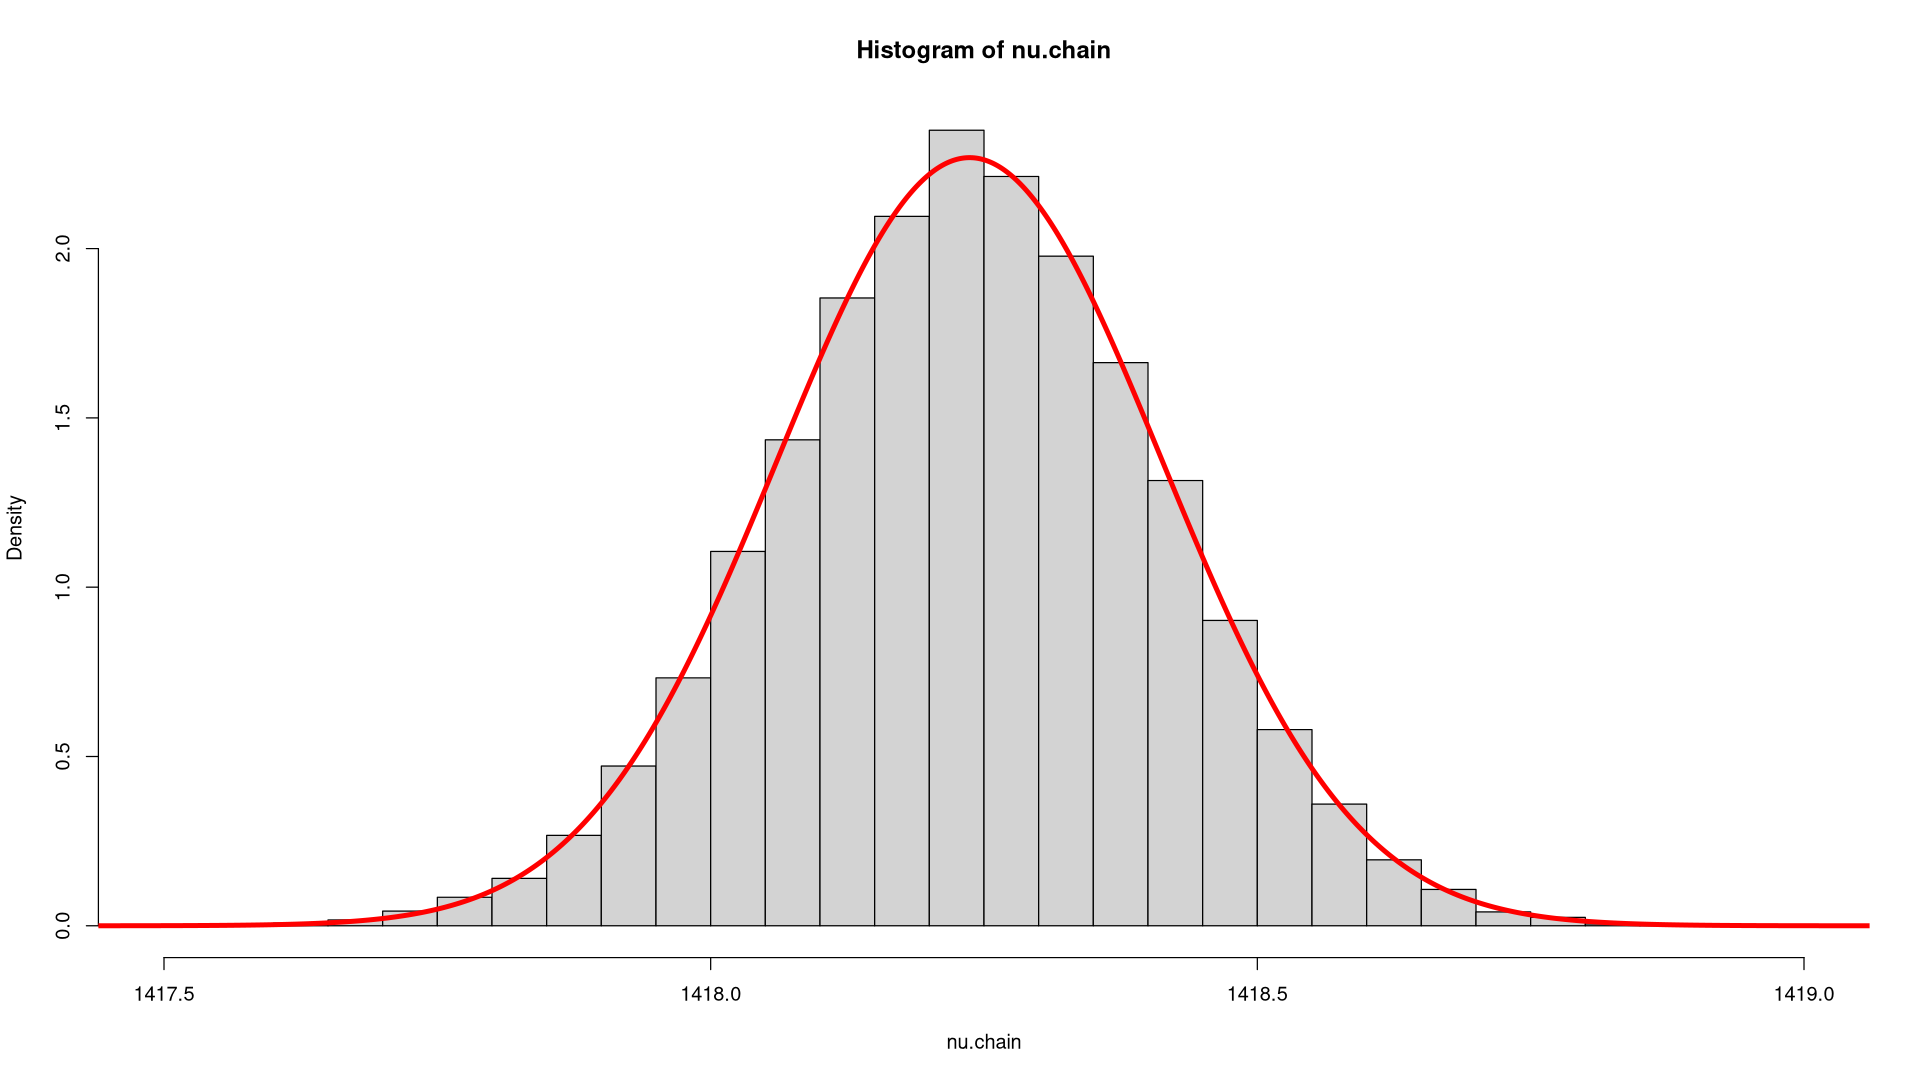

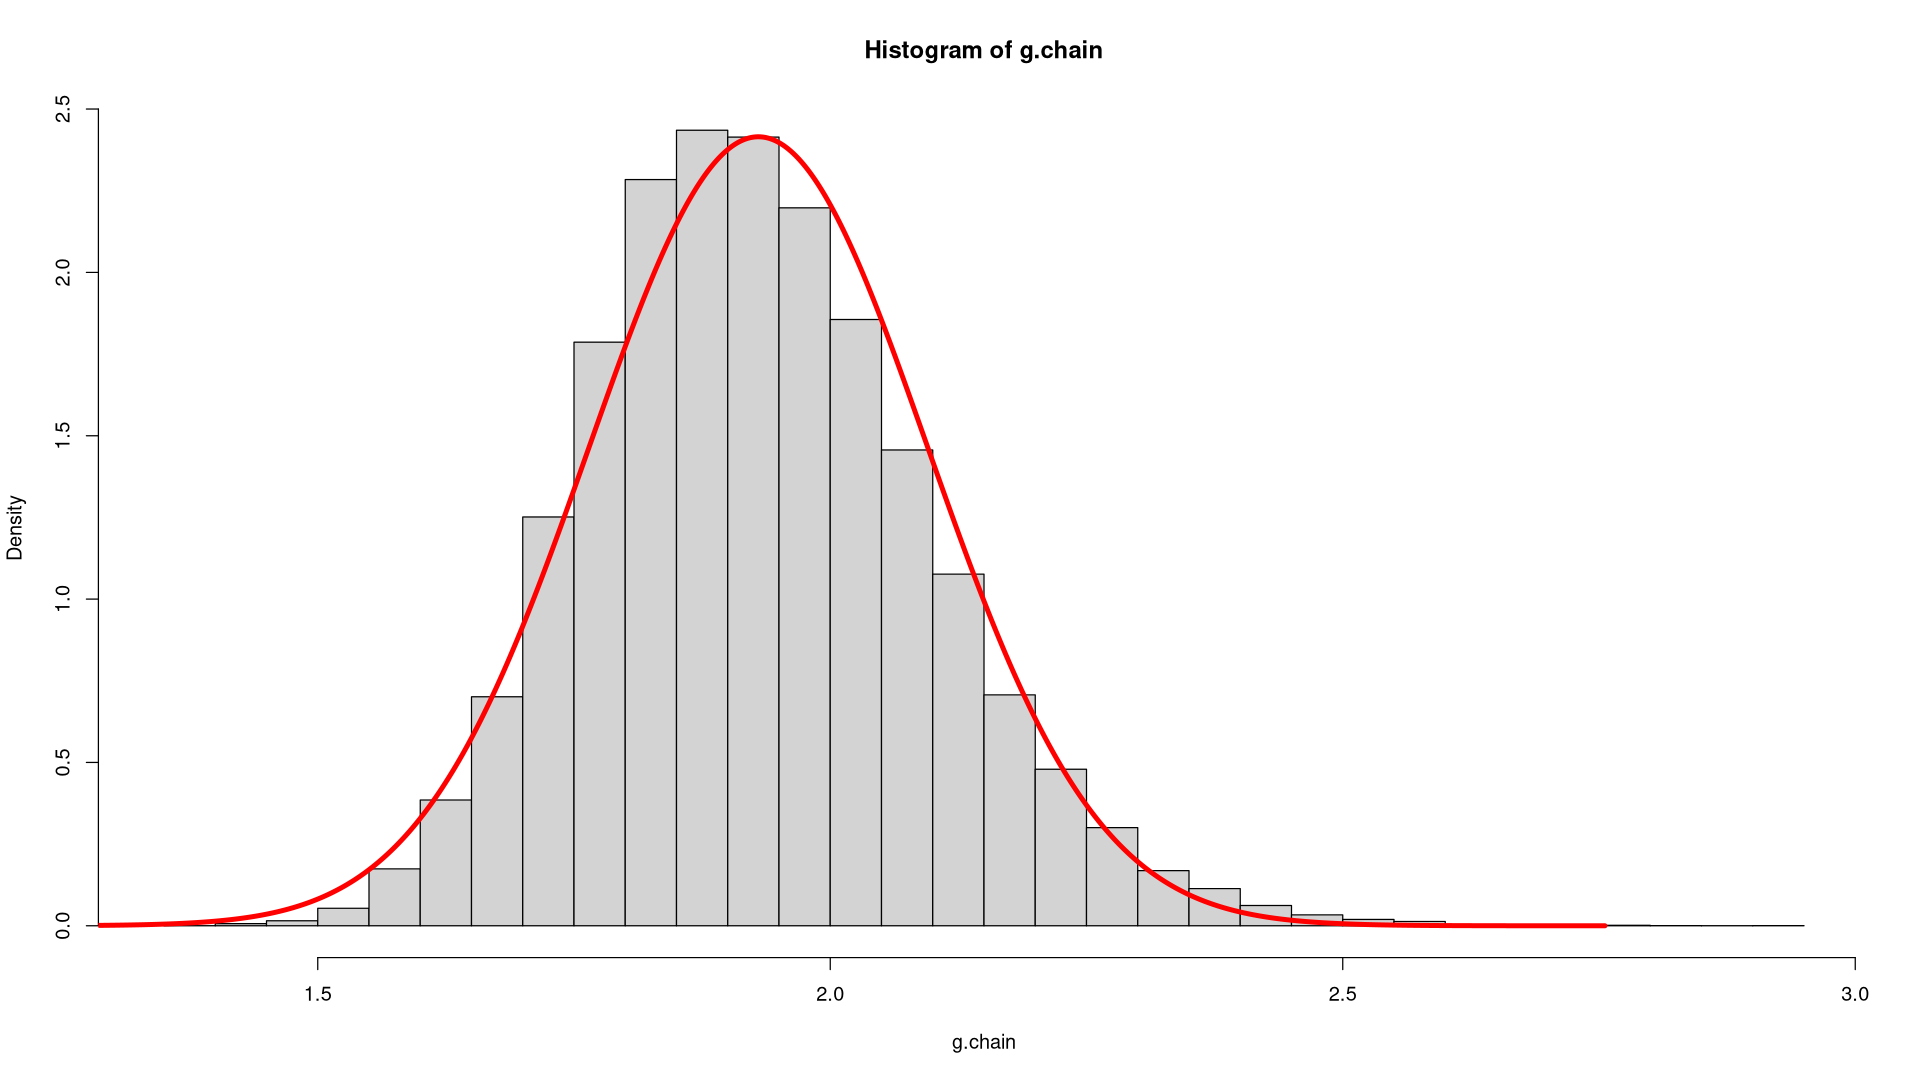

In [36]:
# Histograma p/ nu
hist(nu.chain,freq=FALSE,breaks=40)

x_vals = seq(m_mean.nu - 5*m_sd.nu,
             m_mean.nu + 5*m_sd.nu,
             length.out = 1000)
y_fit = dnorm( x_vals, mean=m_mean.nu, sd=m_sd.nu )
lines(x_vals,y_fit,lwd=4,col='red')

# Histograma p/ g
hist(g.chain,freq=FALSE,breaks=40)

x_vals = seq(m_mean.g - 5*m_sd.g,
             m_mean.g + 5*m_sd.g,
             length.out = 1000)

y_fit = dnorm( x_vals, mean=m_mean.g, sd=m_sd.g )
lines(x_vals,y_fit,lwd=4,col='red')

In [37]:
# Gp.posterior <- function(nu,g){ vec_unnormalized.posterior(nu,g) / m_estimate }
# m_estimate
# #write.table( data.frame(nu.chain,g.chain), file='mcmc.R' , sep=",",  col.names=FALSE, row.names=FALSE)

Resta-me representar graficamente a *joint posterior* de $\nu_0$ e $g$. Optei por fazer isto de duas formas: A primeira foi dando plot à distribuição de probabilidades posterior num gráfico 3D. O código necessário para construir este gráfico encontra-se na célula abaixo do tipo ***RAW NBCONVERT***. Sugiro copiar o código para um *R script* e correr por exemplo em RStudio, uma vez que o Jupyter Notebook não lida bem com este tipo de gráficos.

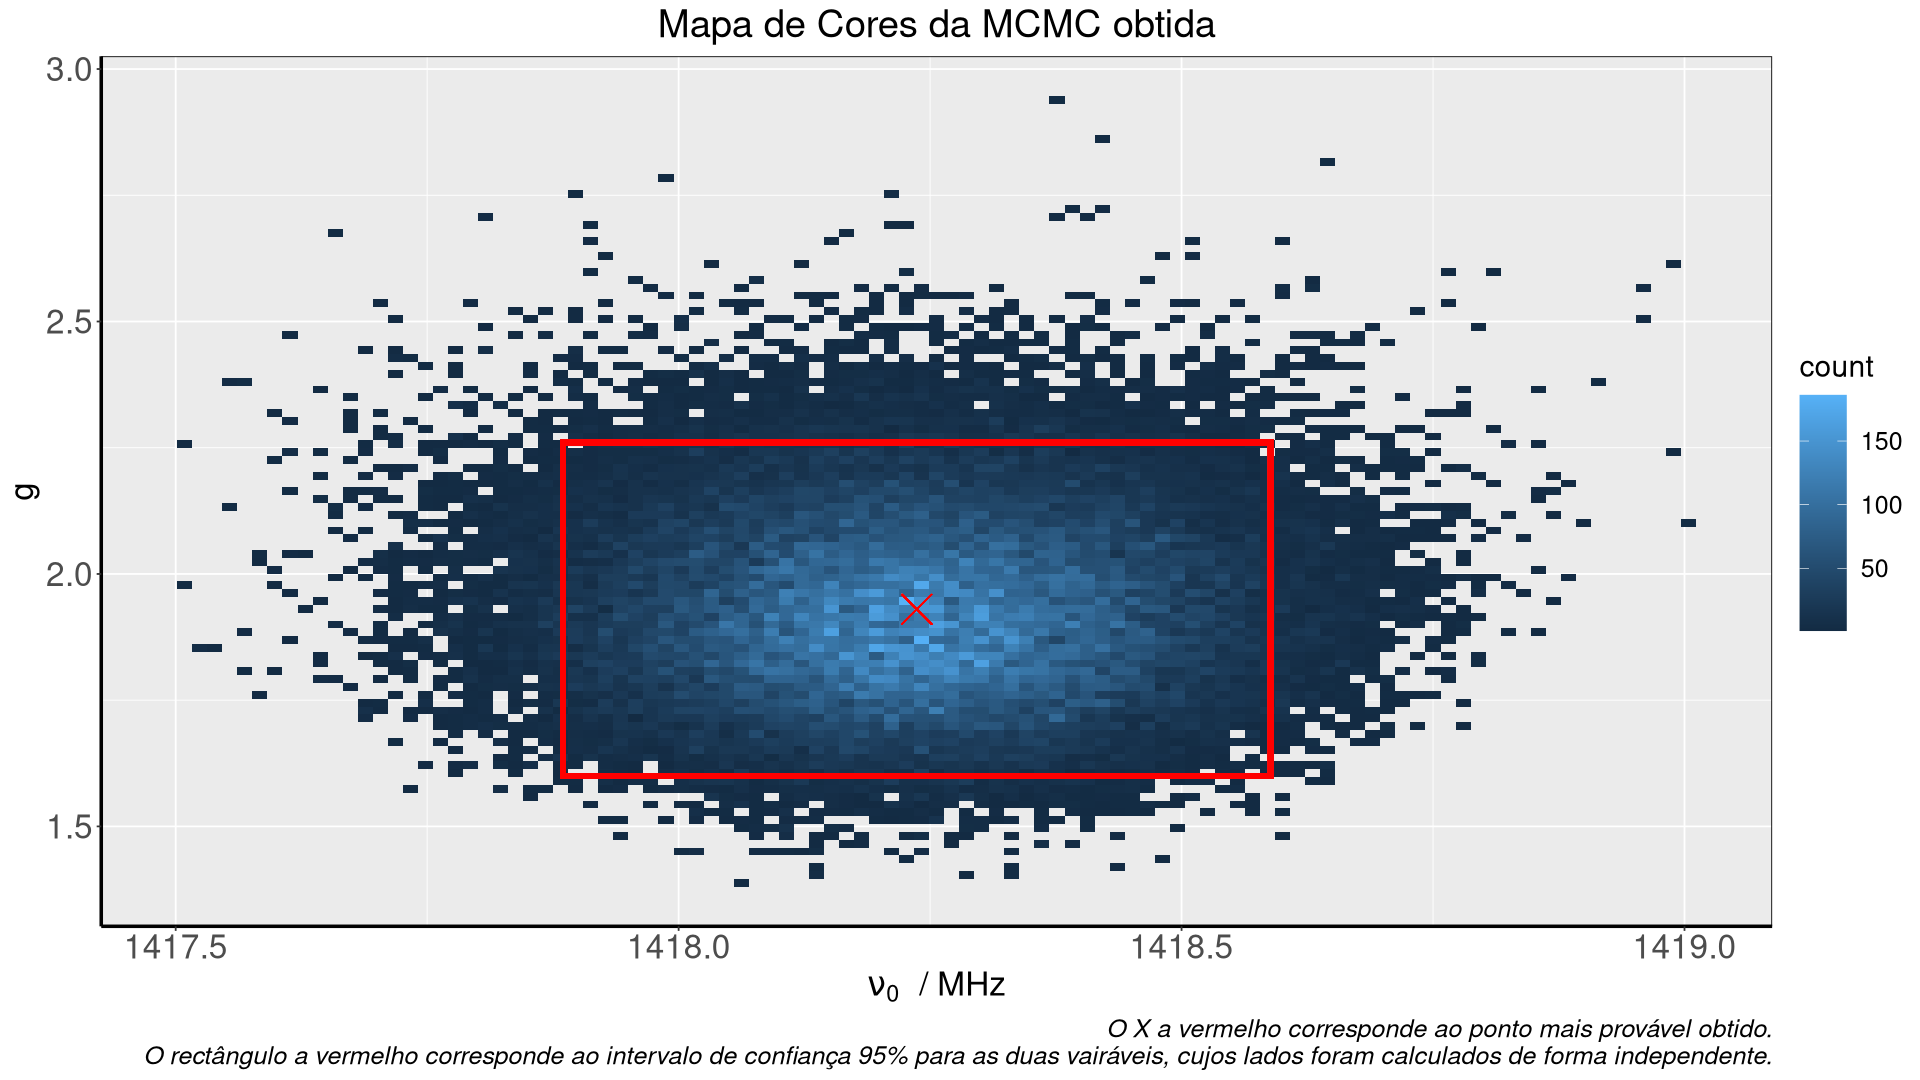

In [38]:
mcmc_hist <- ggplot(mcmc, aes(nu.chain,g.chain)) +
                stat_bin2d(bins = 100) +
                geom_point( aes(x=m_mean.nu, y=m_mean.g) , size = 8, shape = 4, colour="red")+
                geom_rect(mapping=aes(xmin=m_CL.nuL,
                                      xmax=m_CL.nuU,
                                      ymin=m_CL.gL,
                                      ymax=m_CL.gU), fill=NA , size = 1.5,color="red", alpha=1.5)+

                xlab(bquote(nu[0]~' / MHz')) +
                ylab(bquote('g')) +
                labs(title = bquote('Mapa de Cores da MCMC obtida'),
                    caption = bquote('O X a vermelho corresponde ao ponto mais provável obtido.\nO rectângulo a vermelho corresponde ao intervalo de confiança 95% para as duas vairáveis, cujos lados foram calculados de forma independente.')) +
                jupyter.theme()
mcmc_hist

## Conclusões

Neste documento foi analisado o espectro de emissão de um astro com base em métodos de inferência Bayesiana. A primeira parte da discussão, **QA**, passou por determinar qual a probabilidade de existir uma risca de emissão caracterizada por $g = 2$, $G_2^+$, relativamete à *null hypothesis*, $G_0$, que assume um espectro constante. Foi necessário determinar as *marginal likelihoods (ML)* para cada um dos modelos e cheguei à conclusão que, num espaço de modelos $G_0$ e $G_2^+$, a probabilidade do modelo $G_2^+$ ser verdadeiro é

$$
p\left(G_2^+\mid D,I\right) = 1
$$

A ML de $G_0$ foi simples de determinar, sendo necessário apenas um somatório. Por outro lado, para determinar a ML do modelo $G_2^+$ foi necessário integrar numericamente a distribuição de probabilidades. *Estando esclarecido que $G_2^+$ representa os dados com verossemelhança extremamente mais elevada que $G_0$, o próximo passo foi assumir $G_2^+$ como verdadeiro e inferir resultados a partir daí. É com esta informação que seguimos para a **QB**, onde pretendemos determinar a moda, média, mediana e o intervalo de confiança de 95% da probabilidade posterior (ou *pdf*) deste modelo. Os resultados obtidos encontram-se resumidos na tabela abaixo.

<table>
 <thead>
  <tr>
   <th style="text-align:center;">   </th>
   <th style="text-align:center;"> $\nu$ </th>
   <th style="text-align:center;"> $\dfrac{\hat{\nu_0}-\nu}{ d\nu}$   </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> Moda - $\hat{\nu_0}$ </td>
   <td style="text-align:center;"> 1418.241 </td>
   <td style="text-align:center;"> 0 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> Média - $\langle\nu_0\rangle$ </td>
   <td style="text-align:center;"> 1418.241 </td>
   <td style="text-align:center;"> -1.06e-05 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> Mediana - $\nu_{1/2}$ </td>
   <td style="text-align:center;"> 1418.240 </td>
   <td style="text-align:center;"> -6.14e-05 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> CL lower - $\nu_{L}$ </td>
   <td style="text-align:center;"> 1417.806 </td>
   <td style="text-align:center;"> -1.09 </td>
  </tr>
  <tr>
   <td style="text-align:center;"> CL upper - $\nu_{U}$ </td>
   <td style="text-align:center;"> 1418.606 </td>
   <td style="text-align:center;"> 0.914 </td>
  </tr>
</tbody>
</table>

onde $d\nu\, (=0.4)$ representa a sensibilidade (menor escala) das frequências medidas e $\left[\nu_L, \nu_U\right]$ é o menor intervalo de frequências com 95% de probabilidade de conter a frequência verdadeira da risca de emissão, $\nu_0$. A melhor estimativa para $\nu_0$ será, portanto,

$$
\tilde{\nu_0} = 1418.24_{-0.43}^{+0.37}
$$

com 95% de confiança, onde as incertezas superior e inferior correspondem a $\left(\nu_U-\hat{\nu_0}\right)$ e $\left(\hat{\nu_0}-\nu_L\right)$, respetivamente.

Entramos agora na **QC**. Até aqui usei métodos de inferência Bayesiana com apenas um parâmetro livre. No entanto, quando adicionamos outro parâmetro ao modelo, como a amplitude e largura do espectro, dados por $g$ no modelo $G^+$, determinar a ML deste modelo por integração torna-se mais complicado e pouco eficiente/viável. Recorri, portanto, ao algoritmo de Metropolis-Hashtings para gerar *Monte Carlo Markov Chains (MCMC)* com uma amostragem (idealmente) representativa da distribuição de probabilidades, e com isto estimar o integral através de uma soma baseando-me na teoria descrita em [citation]. Seguindo as ideias deste artigo, propûs também que as amostras de $\nu_0$ e $g$ geradas obedeciam a distribuições gaussianas independentes, com média e desvio padrão calculados através dos estimadores da média e variância para cada uma das cadeias. Os coeficientes de correlação entre $\nu_0$ e $g$ foram calculados e observaram-se consistentemente inferiores a 1% para $10^5$ iterações do algoritmo de Metropolis-Hashtings, justificando a minha escolha de gaussianas independentes em vez de uma multivariada.

Mais uma vez, a ML deste modelo é extremamente superior à da *null hypothesis* pelo que

$$
p\left(G^+\mid D,I\right) = 1
$$

Tendo determinado a ML do modelo, os restantes parâmetros pedidos já são sabidos uma vez que assumimos distribuições gaussianas para cada uma das amostras. As melhores estimativas para $\nu_0$ e $g$ obtidas com este método foram

$$
\begin{align}
\tilde{\nu_0} &=1418.24 \pm 0.18\\
\tilde{g} &= 1.94 \pm 0.17
\end{align}
$$

com 95% de confiança para cada um dos parâmetros. Os intervalos de confiança são, portanto,

$$
\begin{align}
\nu_0 &\in \left[1417.86,1418.60\right]\\
g &\in \left[1.60,2.59\right]
\end{align}
$$

As medianas foram determinadas diretamente a partir das cadeias de Markov, obtendo-se

$$
\begin{align}
\nu_{1/2}&= 1418.24\\
g_{1/2} &= 1.92
\end{align}
$$

Fica concluída, assim, a análise do espectro que me foi fornecido.

## Referências
**[1]** Gregory, Phil. **Bayesian Logical Data Analysis for the Physical Sciences** 2005-04 Cambridge University Press

**[2]** Perrakis, Konstantinos / Ntzoufras, Ioannis / Tsionas, Efthymios G. 
**On the use of marginal posteriors in marginal likelihood estimation via importance sampling**
2014-09 